## Chapter 9 Linear two class classification

# 9.1  Logistic regression and the cross-entropy cost

In the previous Chapter we discussed the fitting of a linear model to a set of input/output points - otherwise known as *linear regression*. In general all sorts of nonlinear phenomena present themselves, and the data they generate - whose input and output share a nonlinear relationship - are poorly modeled using a linear model, thus causing linear regression to perform rather poorly. This naturally leads to the exploration of fitting *nonlinear* functions to data, referred to in general as *nonlinear regression*.

In this Section we describe a very particular form of nonlinear regression called *logistic regression* that is designed to deal with a very particular kind of dataset that is commonly dealt with in machine learning/deep learning: *two-class classification data*. This sort of data is distinguished from the sort of data we saw previously by the fact that its output values are constrained to be either one of two fixed values. As we will see, such a constraint naturally leads to the choice of a *logistic sigmoid function* as the ideal nonlinear function to fit to such data, hence the name *logistic regression*. Common examples of two class classification problems include face and general object detection, with classes consisting of with a face or object versus non-facial/object images, textual sentiment analysis where classes consist of written product reviews ascribing a positive or negative opinion, and automatic diagnosis of medical conditions where classes consist of medical data corresponding to patients who either do or do not have a specific malady.  

In [1]:
# This code cell will not be shown in the HTML version of this notebook
# import custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib
datapath = '../../mlrefined_datasets/superlearn_datasets/'

# demos for this notebook
regress_plotter = superlearn.lin_regression_demos
optimizers = optlib.optimizers
static_plotter = optlib.static_plotter.Visualizer();

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 9.1.1 Notation and modeling

Two class classification is a particular instance of *regression* or *surface-fitting*, wherein the output of a dataset of $P$ points $\left\{ \left(\mathbf{x}_{p},y_{p}\right)\right\} _{p=1}^{P}$ is no longer continuous but takes on two fixed numbers.  The actual value of these numbers is in principle arbitrary, but particular value pairs are more helpful than others for derivation purposes (i.e., it is easier to determine a proper nonlinear function to regress on the data for particular output value pairs). Here $y_{p}\in\left\{ 0,\,+1\right\}$ - that is every output takes on either the value $0$ or $+1$. Often in the context of classification the output values $y_p$ are called *labels*, and all points sharing the same label value are referred to as a *class* of data.  Hence a dataset containing points with label values $y_{p}\in\left\{ 0,\,+1\right\}$ is said to be a dataset consisting of two classes.

The simplest shape such a dataset can take is that of a set of linearly separated adjacent 'steps', as illustrated in the figure below. Here the 'bottom' step is the region of the space containing most of the points that have label value $y_p = 0$.  The 'top step' likewise contains most of the points having label value $y_p = +1$. These steps are largely separated by a point when $N = 1$, a line when $N = 2$, and a hyperplane when $N$ is larger (the term 'hyperplane' is also used more generally to refer to a point or line as well).  

As shown in the figure, because its output takes on a discrete set of values one can view a classification dataset 'from above'.  In this 'separator' perspective we remove the vertical $y$ dimension of the data and visually represent the dataset using its input only, displaying the output values of each point by coloring its input one of two unique colors (we choose blue for points with label $y_p = 0$, and red for those having label $y_p = +1$). This separator view allows us to more easily identify the linear boundary that (mostly) separates the two classes.

<figure>
  <img src= '../../mlrefined_images/superlearn_images/Fig_4_10_new.png' width="80%" height="60%" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> Classification from a regression/surface-fitting perspective for single-input (left panels) and two-input (right panels) toy datasets. This surface-fitting view is equivalent to the 'separator' perspective where we look at each respective dataset 'from above'.  In this perspective we can more easily identify the separating hyperplane, i.e., where the step function (shown here in yellow) transitions from its bottom to top step.  In the separator view the vertical axis (the actual $y$ value) is removed, with all points being represented by their input values only.  The label of each point is then represented by color: the points in blue denote label value $0$ while those in red have label $1$. </em>  </figcaption> 
</figure>

This is the simplest sort of dataset with binary output we could aim to perform regression on, as in general the boundary between the two classes of data could certainly be nonlinear. We will deal with this more general potentiality later on - when discussing neural networks, trees, and kernel-based methods - but first let us deal with the current scenario.  How can we perform regression on a dataset like the ones described in the figure above?

## 9.1.2  Trying to fit a discontinuous step function

How can we fit a regression to data that is largely distributed on two adjacent steps separated by a hyperplane? Lets look at a simple instance of such a dataset when $N = 1$ to build our intuition about what must be done in general.

Intuitively it is obvious that simply fitting a line of the form $y = w_0 + w_1x_{\,}$ to such a dataset will result in an extremely subpar results - the line by itself is simply too inflexible to account for the nonlinearity present in the data.  A dataset that is roughly distributed on two steps needs to be fit with a function that matches this general shape. In other words such data needs to be fit with a *step function*.

Since the boundary between the two classes is (assumed to be) linear and the labels take on values that are either $0$ or $1$, ideally we would like to fit a *discontinuous step function with a linear boundary* to such a dataset.  What does such a function look like?  When $N = 1$ it is simply a line $y = w_0 + x_{\,}w_1$ composed with the *step function* $\text{step}\left(\cdot\right)$ where

\begin{equation}
\text{step}\left(w_0 + x_{\,}w_1 \right)
\end{equation}

The identity function is defined as 

\begin{equation}
\text{step}(x) = 
\begin{cases}
1 \,\,\,\,\,\text{if} \,\, x \geq 0.5 \\
0 \,\,\,\,\,\text{if} \,\, x < 0.5 \\
\end{cases}.
\end{equation}

Note here that what happens with $\text{step}(0.5)$ is - for our purposes - arbitrary (i.e., it can be set to any fixed value or left undefined as we have done).

How do we tune the parameters of the line?  We could try to take the lazy way out and *first* fit the line to the classification dataset via linear regression, then compose the line with the sign function to get a step function fit.  However this does not work well in general - as we will see even in the simple instance below.  Instead we need to tune the parameters $w_0$ and $w_1$ *after* composing the line with the sign function, or in other words we need to tune the parameters of $\text{step}\left(w_0 + x_{\,}w_1 \right)$.

#### <span style="color:#a50e3e;">Example 1: </span> Fitting a line first and taking the sign afterward fails to represent a two-class dataset well

In the Python cell below we load in a simple two-class dataset (top panel), fit a line to this dataset via linear regression, and then compose the fitted line with the sign function to produce a step function fit. Both the linear fit (in green) as well as its composition with the sign function (in dashed red) are shown along with the data in the bottom panel.  Of course the line itself provides a terrible representation of the nonlinear dataset. But its evaluation through sign is also quite poor for such a simple dataset, failing to properly identify two points on the top step. In the parlance of classification these types of points are referred to as *misclassified points*.

<IPython.core.display.Javascript object>


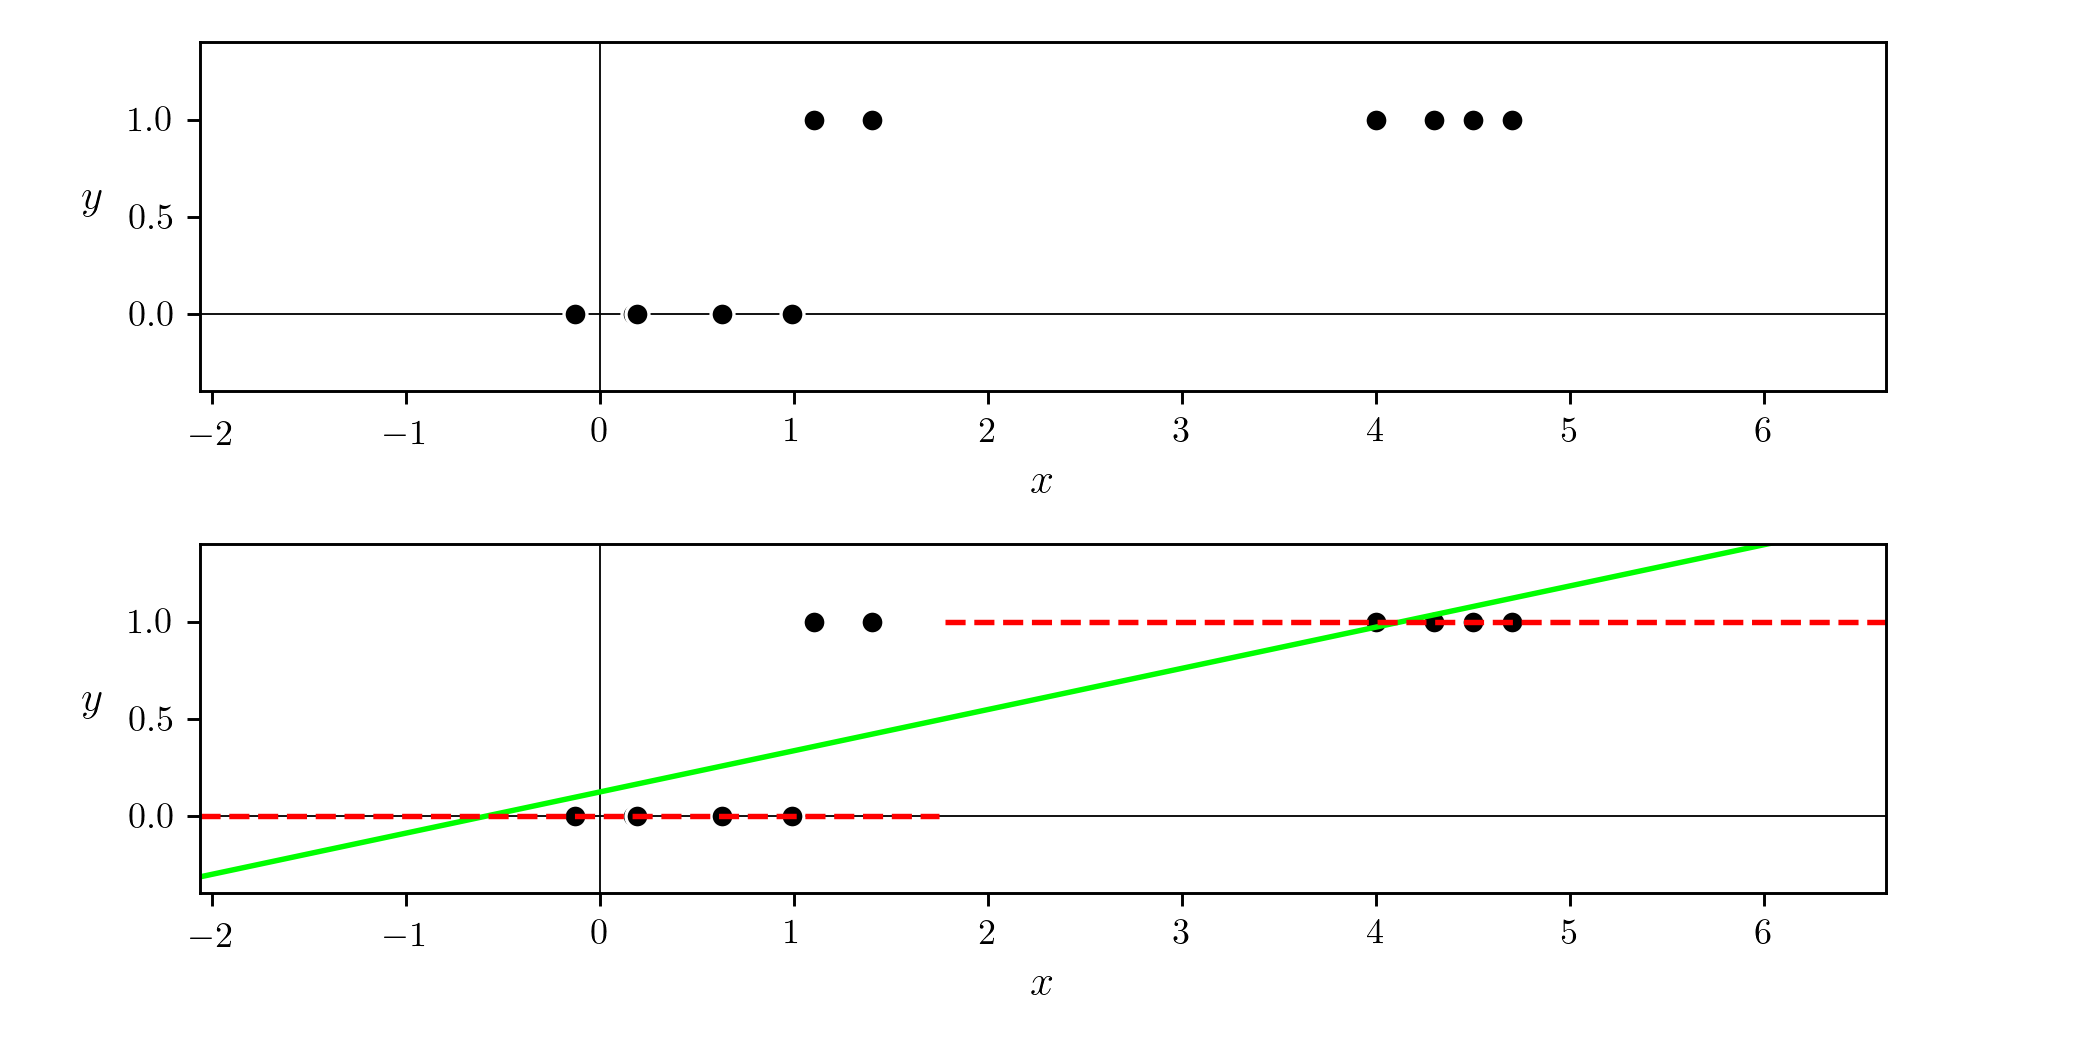

In [2]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
data = np.loadtxt(datapath + '2d_classification_data_v1_entropy.csv',delimiter = ',')

# create instance of linear regression demo, used below and in the next examples
demo1 = superlearn.logistic_regression_simple_demos_entropy.visualizer(data)
demo1.run_algo(algo = 'newtons_method',w_init = [-1,-1], max_its = 1)

# plot dataset
demo1.naive_fitting_demo()

----

How do we tune these parameters properly? As with linear regression, here we can try to setup a proper Least Squares function that - when minimized - recovers our ideal weights. We can do this by simply reflecting on the sort of ideal relationship we want to find between the input and output of our dataset. 

Take a single point $\left(x_p,\,y_p \right)$. Notice in the example above - and this is true more generally speaking - that ideally for a good fit we would like our weights to be such if this point has a label $+1$ it lies in the positive region of the space where $w_0 + xw_1 > 0$ so that $\text{step}\left(w_0 + w_1x_p\right) = +1$ matches its label value.  Likewise if this point has label $0$ we would like it to lie in the negative region where $w_0 + xw_1 < 0$ so that $\text{step}\left(w_0 + x_pw_1\right) = 0$ matches its label value. So in short what we would ideally like for this point is that its evaluation matches its label value, i.e., that

\begin{equation}
\text{step}\left(w_0 + x_pw_1 \right) = y_p 
\end{equation}

And of course we would like this to hold for every point.  To find weights that satisfy this set of $P$ equalities as best as possible we could - as we did previously with linear regression - square the difference between both sides of each and average them, giving the Least Squares function

\begin{equation}
g(w_0,w_1) = \frac{1}{P}\sum_{p=1}^P \left(\text{step}\left(w_0 + x_pw_1 \right) - y_p \right)^2
\end{equation}

which we can try to minimize in order to recover weights that satisfy our desired equalities. If we can find a set of weights such that $g(w_0,w_1) = 0$ then all $P$ equalities above hold true, otherwise some of them do not. Notice: the evaluation of this Least Squares cost for any given $w_0$ and $w_1$ is (four times) the number of *misclassified points* for that particular choice of weights, and as a result is always integer valued. Because it counts the number of misclassifications this cost function is often referred to as the *counting cost* for two-class classification.

Unfortunately because the counting cost takes on only integer values it is impossible to minimize with our gradient-based techniques, as at every point the function is completely flat, i.e., it has exactly zero gradient. Because of this neither gradient descent nor Newton's method can take a single step 'downhill' regardless of where they are initialized. This problem is inherited from our use of the sign function, itself a discontinuous step.

#### <span style="color:#a50e3e;">Example 2: </span> Visualizing the counting cost on a simple dataset

In the next Python cell we plot the counting cost (left panel) for the dataset displayed in Example 1, over a wide range of values for $w_0$ and $w_1$.  The counting cost surface consists of discrete steps at many different levels, each one completely flat.  Because of this no local method can be used to minimize the counting cost.

In the middle and right panels we plot the surfaces of two related cost functions on the same dataset.  We introduce the cost function shown in the middle panel in the next subection, and the cost in the right panel in the one that follows.  We can indeed minimize either of these using a local method to recover ideal weights.

<IPython.core.display.Javascript object>


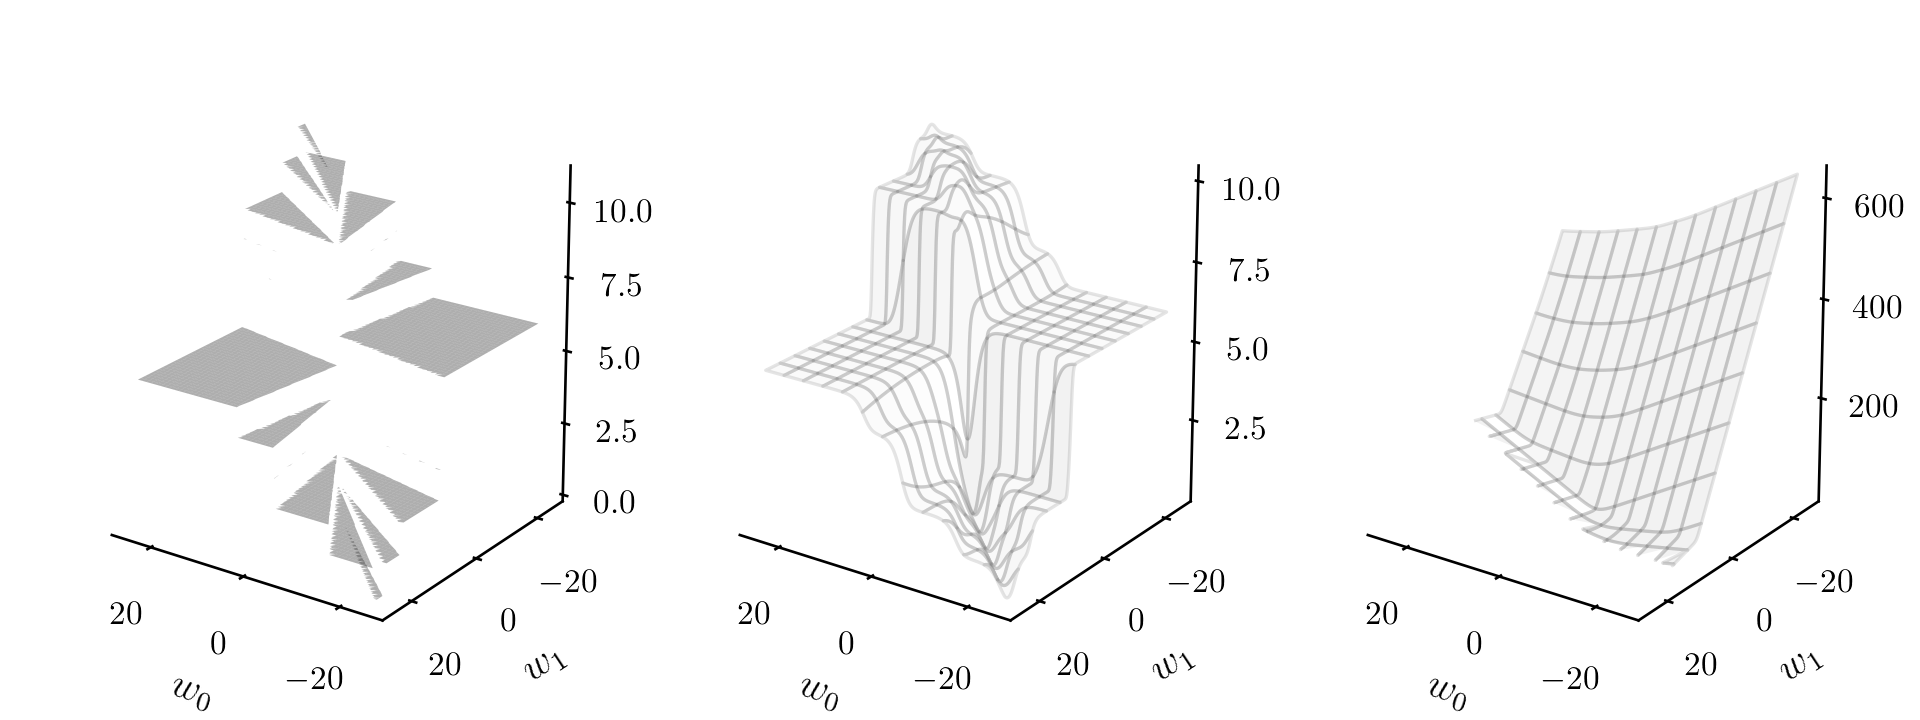

In [28]:
# This code cell will not be shown in the HTML version of this notebook
# create an instance of the visualizer and plot
demo2 = superlearn.cost_viewer_entropy.Visualizer(data)
demo2.plot_costs(viewmax = 25,view = [20,125])

## 9.1.3  Non-convex least squares logistic regression

As mentioned above, we cannot directly minimize the counting cost due to our use of the sign function. In other words, we cannot directly fit a *discontinuous* step function to our data. In order to go further we need to replace the sign, ideally with a *continuous* function that matches it very closely everywhere. Thankfully such a function is readily available: the sigmoid function, $\sigma(\cdot)$.  This kind of function is alternatively called a *logistic* function - and when we fit such a function to a classification dataset we are therefore performing regression with a logistic or *logistic regression*.

In the figure below we plot the sigmoid function (left panel), as well as several internally weighted versions of it (right panel). As we can see in the figure, for the correct setting of internal weights the hyperbolic tangent function can be made to look arbitrarily similar to the step function.

<figure>
  <img src= '../../mlrefined_images/superlearn_images/Fig_4_11_new.png' width="80%" height="80%" alt=""/>
  <figcaption>   
<strong>Figure 2:</strong> <em> (left panel) Plot of the sigmoid function $\text{tanh}(x)$. (right panel) By increasing the weight $w$ in $\sigma(wx)$ from $w=1$ (shown in red) to $w=2$ (shown in green) and finally to $w=10$ (shown in blue), the internally weighted version of the sigmoid function becomes an increasingly
good approximator of the step function. </em>  </figcaption> 
</figure>

Swapping out the step function with sigmoid in equation (2) we aim to satisfy as many of the $P$ equations

\begin{equation}
\sigma\left(w_0 + x_pw_1 \right) = y_p \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1,..,P
\end{equation}

as possible.  To *learn* parameters that force these approximations to hold we can do precisely what we did in the case of linear regression: try to minimize the e.g., the squared error between both sides as 

\begin{equation}
\left(\sigma\left(w_0 + x_pw_1 \right) - y_p \right)^2 \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1,..,P.
\end{equation}

Taking the average of these squared errors gives a Least Squares cost for *logistic regression*

\begin{equation}
g\left(w_0,w_1\right) = \frac{1}{P}\sum_{p=1}^P \left(\sigma\left(w_0 + x_pw_1 \right) - y_p \right)^2
\end{equation}

This function - an example of which is plotted in the previous example - is generally non-convex and contains large flat regions.  Because of this - as we saw in Chapters 6 and 7 - this sort of function is not easily minimized using stanard gradient descent or Newtons method algorithms.  Specialized algorithms - like the normalized gradient descent scheme presented in Chapter 6 - can be employed successfully as we show in the example below.   However it is more commonplace to simply employ a different and *convex* cost function based on the set of desired approximations in equation (4).  We do this following the example.

#### <span style="color:#a50e3e;">Example 1. </span>  Normalized gradient descent for Least Squares logistic regression 

Recall that in discussing logistic regression in Chapter 9 we derived the non-convex Least Squares cost function 

\begin{equation}
g\left(w_0,w_1\right) = \sum_{p=1}^P \left(\sigma\left(w_0 + x_pw_1 \right) - y_p \right)^2
\end{equation}

which was immediately discarded in favor of the convex softmax cost, because our original unnormalized version of gradient descent would easily get stuck in the flat regions of the former cost.

In this example we show how normalized gradient descent can be used to minimize the logistic Least Squares cost, translated into Python in the next cell.

In [3]:
# define sigmoid function
def sigmoid(t):
    return 1/(1 + np.exp(-t))

# sigmoid non-convex logistic least squares cost function
def sigmoid_least_squares(w):
    cost = 0
    for p in range(y.size):
        x_p = x[:,p]
        y_p = y[:,p]
        cost += (sigmoid(w[0] + w[1]*x_p) - y_p)**2
    return cost/y.size

First, we load in a simulated one-dimensional dataset (left panel) and plot its corresponding tanh Least Squares cost (right panel).

<IPython.core.display.Javascript object>


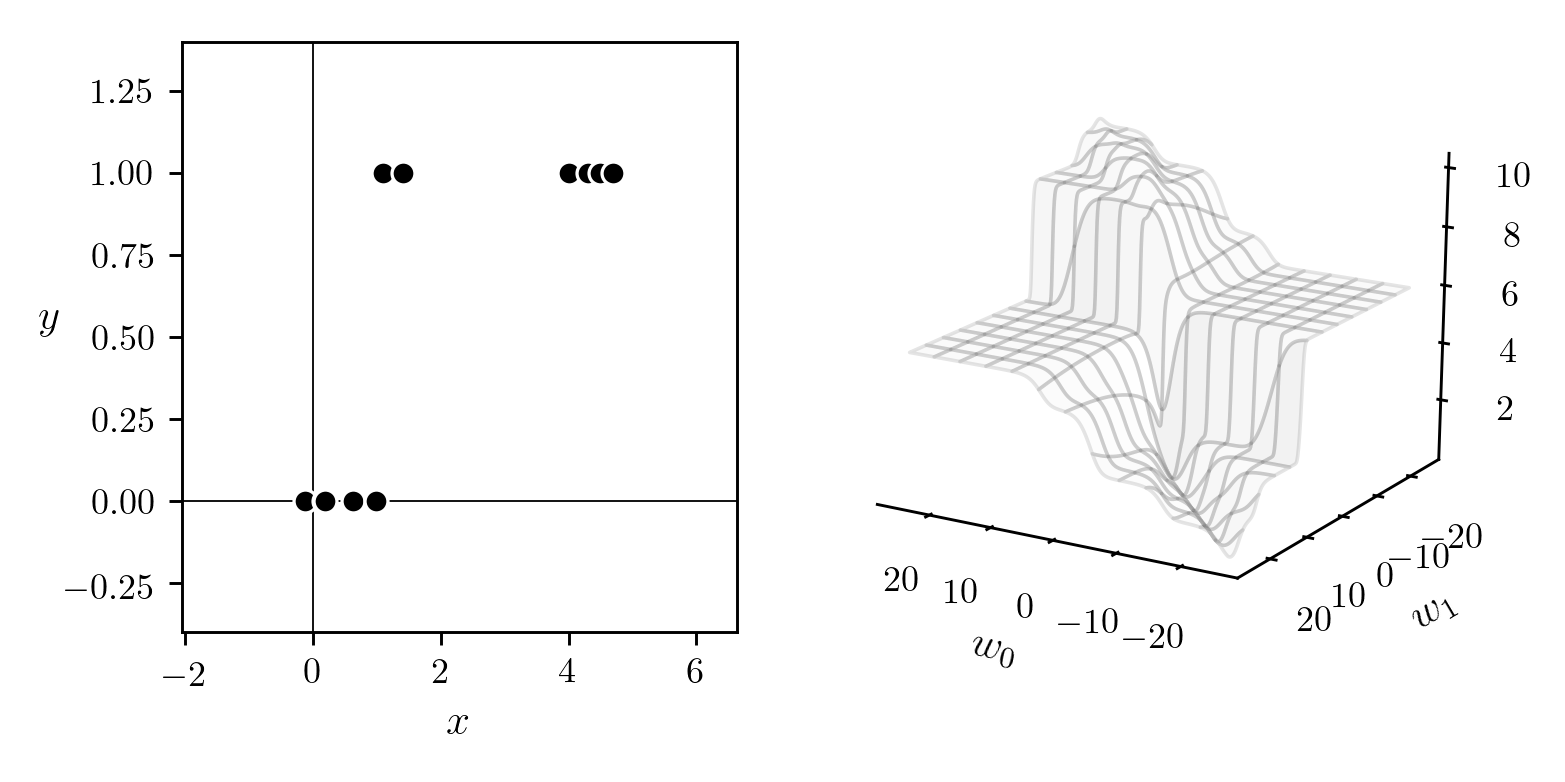

In [4]:
# This code cell will not be shown in the HTML version of this notebook
data = np.loadtxt(datapath + '2d_classification_data_v1_entropy.csv', delimiter = ',')

# create an instance of the visualizer and plot
demo = superlearn.LS_sigmoid.Visualizer(data)
demo.plot_costs(viewmax = 25, view = [21,121])

We now run normalized gradient descent for $900$ iterations, initialized at $w_0=-w_1=20$, with steplength parameter fixed at $\alpha=1$.  

In [5]:
# This code cell will not be shown in the HTML version of this notebook
opt = superlearn.optimizers.MyOptimizers()

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# run normalized gradient descent
w = np.asarray([20.0,-20.0])[:,np.newaxis]
w_hist = opt.gradient_descent(g = sigmoid_least_squares,w = w,version = 'normalized',max_its = 900, alpha = 1)

The cell below plots the Least Squares logistic regression fit to the data (left panel) along with the gradient descent  path towards the minimum on the contour plot of the cost function (right panel). The normalized gradient descent steps are colored green to red as the run progresses.  

<IPython.core.display.Javascript object>


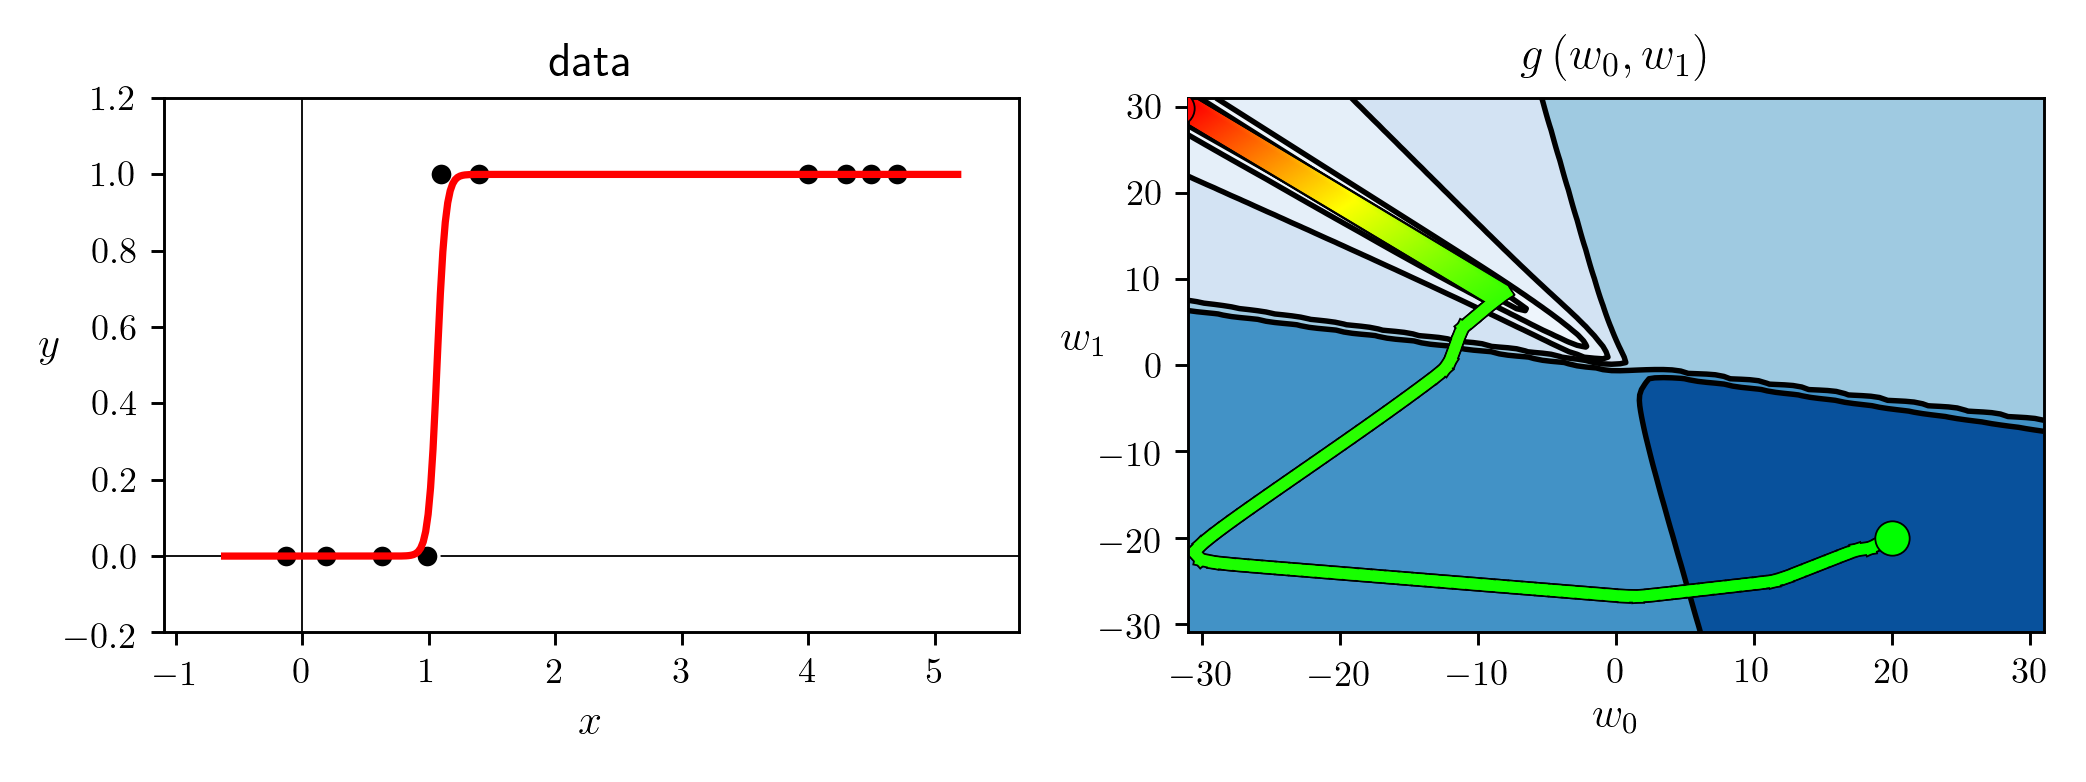

In [6]:
# This code cell will not be shown in the HTML version of this notebook
# create instance of logisic regression demo and load in data, cost function, and descent history
demo2 = superlearn.classification_2d_demos_entropy.Visualizer(data,sigmoid_least_squares)

# create a static figure illustrating gradient descent steps 
demo2.static_fig(w_hist,num_contours = 25,viewmax = 31)

## 9.1.4  Cross-entropy cost for logistic regression

There is more than one way to form a cost function whose minimum forces as many of the $P$ equalities in equation (4) to hold as possible.  The squared error $\left(\sigma\left(w_0 + x_pw_1\right) - y_p\right)^2$ penalty works universally, regardless of the values taken by the output by $y_p$.  However because we *know* that the output we deal with now is limited to the *discrete* values $y_p \in \left\{0,1\right\}$ it is reasonable to ask if we cannot create a more appropriate cost that is customized to deal with just such output.

Such a penalty does exist for these restricted output values, is called the *cross-entropy*, and is defined as follows

\begin{equation}
\text{penalty}\left(w_0,w_1\right)=
\begin{cases}
-\text{log}\left(\sigma\left(w_0 + x_pw_1\right) \right) \,\,\,\,\,\,\,\,\,\,  \,\,\,\,  \text{if} \,\, y_p = 1 \\
-\text{log}\left(1 - \sigma\left(w_0 + x_pw_1\right) \right) \,\,\,\,\,\text{if} \,\, y_p = 0. \\
\end{cases}
\end{equation}

First notice that *regardless of the weight values* this penality is *always nonnegative* and takes on a minimum value at $0$. 

Second notice how this penalizes violations of our desired equalities in equation (4) (and much more harshly than a least squares penalty too).  Suppose we have our *optimally tuned our weights* and that $y_p = 1$.  Then with our ideal weights we should satisfy our desired equality and have $\sigma\left(w_0 + x_pw_1\right)  \approx y_p = 1$, and if this indeed the case then $-\text{log}\left(\sigma\left(w_0 + x_pw_1\right) \right) \approx  -\text{log}\left(1\right) = 0$ which is a neglibable penalty.  However if $\sigma\left(w_0 + x_pw_1\right)  < 1$ the value $-\text{log}\left(\sigma\left(w_0 + x_pw_1\right) \right)$ *becomes large and positive very quickly harshly penalizing violations of our desired equality*.   As $\sigma\left(w_0 + x_pw_1\right) $ approaches $0$ - the worst possible value it could take on if indeed $y_p = 1$ - then penalty value goes to *positive infinity*.  So indeed, this penalty function penalizes violations when $y_p = 1$ very strictly and is minimal (equals $0$) in value when the desired equality holds.  Precisely the same thing can be said when $y_p = 0$, that this penalty takes on a minimal value when $\sigma\left(w_0 + x_pw_1\right)  \approx 0$ and is very large otherwise going to positive infinity as $\sigma\left(w_0 + x_pw_1\right) $ approaches the worst possible value of $1$.  

So - in short - penalty severely punishes violations of our desired equalitiesa and takes on a minimum value of $0$ when our weights $w_0$ and $w_1$ are properly tuned i.e.,

\begin{equation}
\text{penalty}\left(w_0,w_1\right)\approx 0.
\end{equation}

Finally note that this penalty can be equivalently written - combining the two cases -  in a single line as

\begin{equation}
\text{penalty}\left(w_0,w_1\right)=
-y_p\text{log}\left(\sigma\left(w_0 + x_pw_1\right) \right) 
-\left(1-y_p\right)\text{log}\left(1 -\sigma\left(w_0 + x_pw_1\right) \right).
\end{equation}

Taking the average of these $P$ expressions - one per datapoint - gives the commonly used *cross-entropy* cost function for logistic regression 

\begin{equation}
g\left(w_0,w_1\right) = - \frac{1}{P}\sum_{p=1}^Py_p\text{log}\left(\sigma\left(w_0 + x_pw_1\right) \right) 
+\left(1-y_p\right)\text{log}\left(1 - \sigma\left(w_0 + x_pw_1\right) \right)
\end{equation}

Using the same logic that led us to this cost for $N = 1$ dimensional input, we can derive the same set of desired equalities in equation (4) and - likewise - the same cross-entropy cost as

\begin{equation}
g(\mathbf{w}) = -\frac{1}{P}\sum_{p=1}^P  y_p\text{log}\left(\sigma\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right)\right) + \left(1 - y_p\right)\text{log}\left(1 - \sigma\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right)\right)                 
\end{equation}

where we have written the general linear combination

\begin{equation}
\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}  = w_{0}+ x_{1,p}w_{1} + x_{2,p}w_{2} + \cdots + x_{N,p}w_{N} 
\end{equation}

employing our compact vector notation first introduced in Section 5.1

\begin{equation}
\mathbf{w}=
\begin{bmatrix}
w_{0}\\
w_{1}\\
w_{2}\\
\vdots\\
w_{N} 
\end{bmatrix}
\,\,\,\,\,\text{and}\,\,\,\,\,\,
\mathring{\mathbf{x}}_p=
\begin{bmatrix}
1\\
x_{1,p}\\
x_{2,p}\\
\vdots\\
x_{N,p}
\end{bmatrix}.
\end{equation}

And of course both the counting cost and logistic Least Squares cost (in equations (3) and (5) respectively) can be expressed for general $N$ dimensional input using this compact notation as well. 

Recall, how each of these costs correspond to a different *non-linear* surface being fit to the data in the input-output space: with the counting cost it is an ideal step function, while with logistic Least Squares and cross-entropy it is a smooth approximation to the step function. However in all cases, the classifier separating the two classes in the input space of the problem is defined by  

\begin{equation}
\mathring{\mathbf{x}}_{\,}^{T}\mathbf{w}^{\,}=0.5
\end{equation}

as shown in Figure 1, which by virtue of being a hyperplane (i.e., a linear model) makes logistic regression a *linear classifier*, regardless of the cost function employed. 

And indeed in general to optimally tune the parameters $\mathbf{w}$ we want to *minimize* the cross-entropy cost as 

\begin{equation}
\underset{\mathbf{w}}{\mbox{minimize}}\,\, -\frac{1}{P}\sum_{p=1}^P  y_p\text{log}\left(\sigma\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right)\right) + \left(1 - y_p\right)\text{log}\left(1 - \sigma\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right)\right) 
\end{equation}

since the smaller this cost function becomes the better we have tuned our parameters $\mathbf{w}$.

> While logistic regression fits a nonlinear surface to classification data in the input-output space, the decision boundary in the input space is always linear - a hyperplane - and as a result logistic regression is considered a *linear classifier*.

## 9.1.5  Implementing and minimizing a modular softmax logistic regression cost in `Python`

We can implement the softmax costs very similarly to the way we did the Least Sqwuares cost for linear regression, as detailed in Section 8.1.3, breaking down our implementation into the linear `model` and the error itself.  Our linear `model` takes in both an appended input point $\mathring{\mathbf{x}}_p$ and a set of weights $\mathbf{w}$ 

\begin{equation}
\text{model}\left(\mathbf{x}_p,\mathbf{w}\right) = \mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}.
\end{equation}

With this notation for our model, the corresponding softmax cost in equation (16) can be written

\begin{equation*}
g(\mathbf{w}) = \frac{1}{P}\sum_{p=1}^P\text{log}\left(1 + e^{-y_p^{\,}\text{model}\left(\mathbf{x}_p,\mathbf{w}\right)}\right).
\end{equation*}

We can then implement the cost in chunks - first the `model` function below precisely as we did with linear regression.

In [11]:
# compute linear combination of input point
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

Note here that the *implementation* differs slightly from the algebraic form of the linear `model`, taking in the original input and forming the compact version (stacking a $1$ atop each input) once inside.  As we discussed with linear regression, this is a design choice we make so specifically so that we can more cleanly implement input normalization schemes (which we saw for linear regression in Section 8.4, and for which we will see for linear two-class classification in Section 9.4).

The softmax implementation is then - employing efficient and compact `numpy` operations (see the general discussion in Section 8.1.3) as 

In [12]:
# the convex cross-entropy cost function
def cross_entropy(w):
    # compute sigmoid
    a = sigmoid(model(x,w))
    
    # compute cross-entropy
    cost = np.sum(y*np.log(a) + (1-y)*np.log(1-a))
    return cost/y.size

The softmax cost is *always convex* regardless of the dataset used - we will see this empirically in the examples below and a mathematical proof is provided in the appendix of this Section that verifies this claim more generally (one can also compute a conservative but provably convergent steplength parameter $\alpha$ for the softmax cost based on its Lipschitz constant, which is also described in the appendix). We displayed a particular instance of the cost surface in the right panel of Example 2 for the dataset first shown in Example 1. Looking back at this surface plot we can see that it is indeed convex.

Since the softmax cost function is convex a variety of local optimization schemes can be used to properly minimize it properly.  For these reasons - as well as for the fact that a probabilistic approach for deriving logistic regression leads to a cost function equivalent to the softmax cost above as we will see later in this Section - the softmax cost is used more often in practice for logistic regression than is the logistic Least Squares cost for linear classification.

> The softmax cost is more widely used in practice for logistic regression than the logistic Least Squares cost. Being always convex we can use Newton's method to minimize the softmax cost, and we have the added confidence of knowing that local methods (gradient descent and Newton's method) are assured to converge to its global minima.

As alternative to using an Automatic Differentiator (which we use by default - employing `autograd` - see Section 3.11), one can perform gradient descent here by hand-computing the gradient of the softmax cost function.  Using the simple derivative rules outlined in Chapter 3 gradient can be computed as 

\begin{equation}
\nabla g\left(\mathbf{w}\right) = - \frac{1}{P}\sum_{p = 1}^P \frac{ e^{-\overset{\,}{y}_p^{\,}\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,} }}{1 + e^{-\overset{\,}{y}_p^{\,}\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}}}\overset{\,}{y}_p^{\,}\mathring{\mathbf{x}}_{p}^{\,}
\end{equation}


Writing the gradient in this wah helps avoid numerical problems associated with using the exponential function on a modern computer. This is due to the exponential
'overflowing' with large exponents, e.g., $e^{1000}$, as these numbers are too large to store explicitly on the computer and so are
represented symbolically as $\infty$. This becomes a problem when evaluating $\frac{e^{1000}}{1+e^{1000}}$
which, although basically equal to the value $1$, is thought of by the computer to be a NaN (not a number) as it thinks $ $$\frac{e^{1000}}{1+e^{1000}}=\frac{\infty}{\infty}$
which is undefined. By writing each summand of the gradient such that it has an exponential in its denominator only, we avoid the problem
of dividing two overflowing exponentials.

In addition to employ Newton's method 'by hand' one can hand compute the Hessian of the softmax function as

\begin{equation}
\nabla^2 g\left(\mathbf{w}\right) =  \frac{1}{P}\sum_{p = 1}^P \left( \frac{1}{1 + e^{\overset{\,}{y}_p^{\,}\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}}} \right)  \left( 1 - \frac{1}{1 + e^{\,\overset{\,}{y}_p^{\,}\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}}} \right)    \mathring{\mathbf{x}}_p^{\,}\mathring{\mathbf{x}}_p^T.
\end{equation}

#### <span style="color:#a50e3e;">Example 3: </span> Using gradient descent to perform logistic regression using the softmax cost

In this example we repeat the experiments of Example 2 using the softmax cost and gradient descent. 

With our cost function defined in ``Python`` we can now run our demonstration. We initialize at the point $w_0 = 3$ and $w_1 =3$, set $\alpha = 1$, and run for 25 steps.  

In [13]:
# This code cell will not be shown in the HTML version of this notebook
# take input/output pairs from data
x = data[:-1,:]
y = data[-1:,:] 

# run gradient descent to minimize the softmax cost
g = cross_entropy; w = np.array([3.0,3.0])[:,np.newaxis]; max_its = 100; alpha_choice = 1;
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

Each step of the run is now animated - along with its corresponding fit to the data.  In the left panel both the data and the fit at each step (colored green to red as the run continues) are shown, while in the right panel the contour of the cost function is shown with each step marked (again colored green to red as the run continues).  Moving the slider from left to right animates the run from start to finish. Note how we still have some zig-zagging behavior here, but since we can safely use unnormalized gradient descent, its oscillations rapidly decrease in magnitude since the length of each step is directly controlled by the magnitude of the gradient.


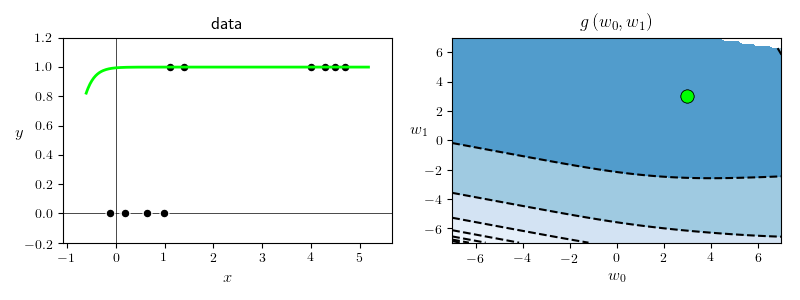
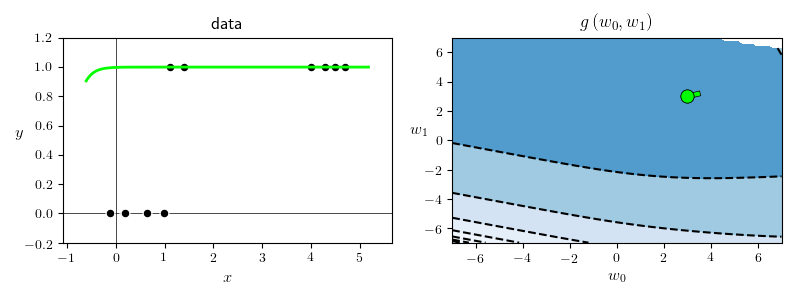
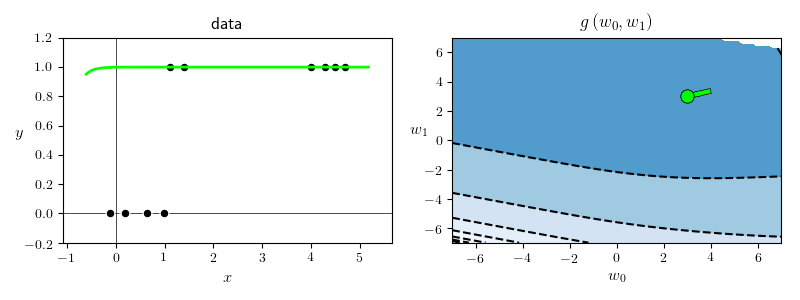
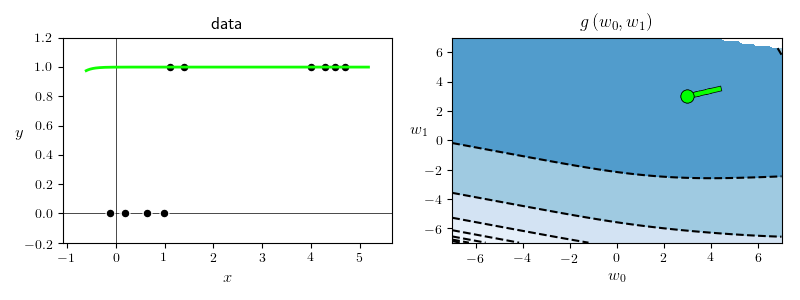
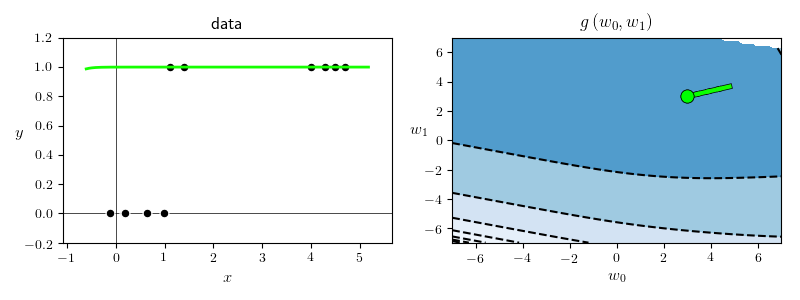
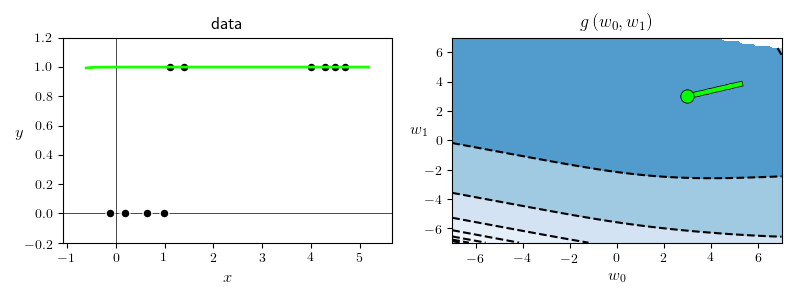
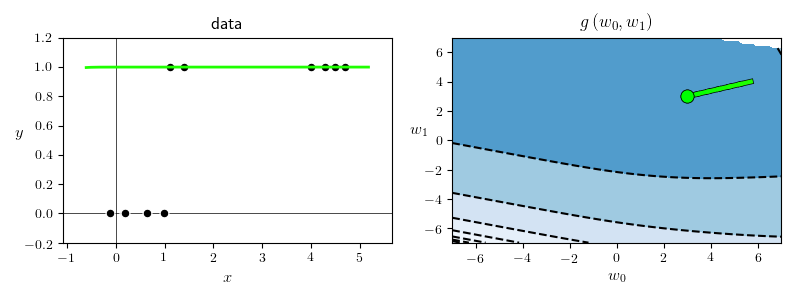
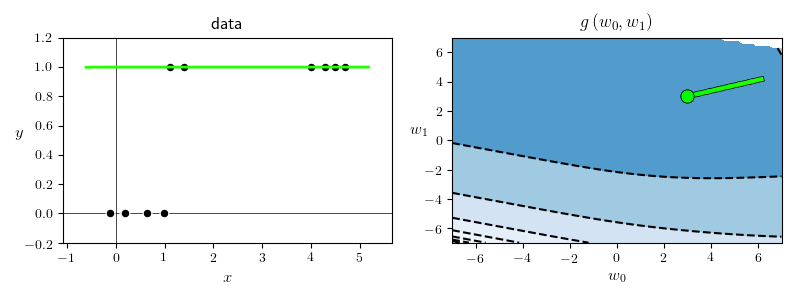
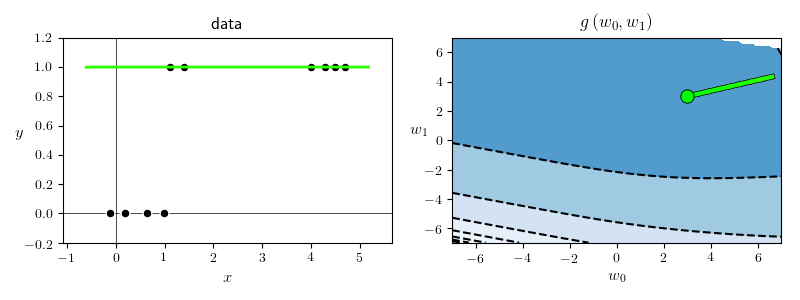
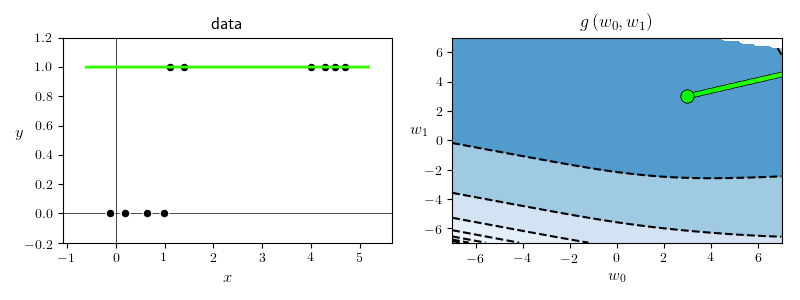
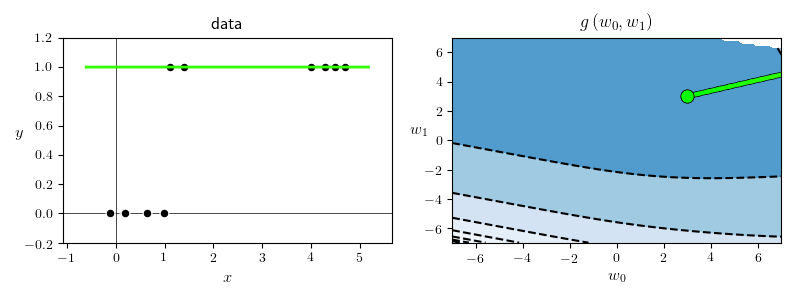
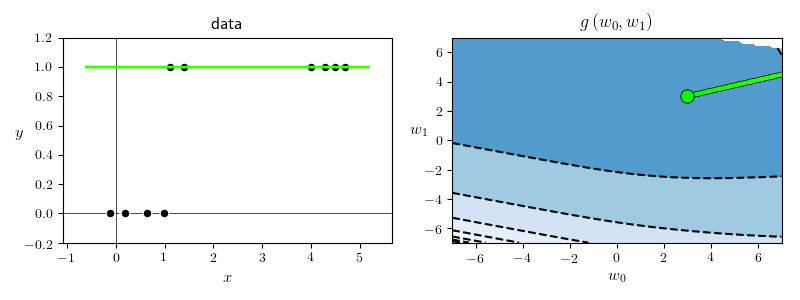
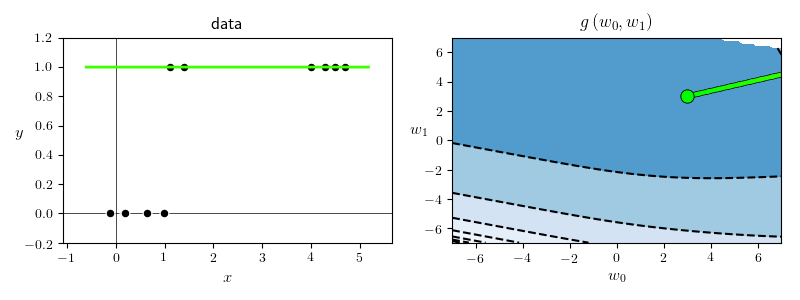
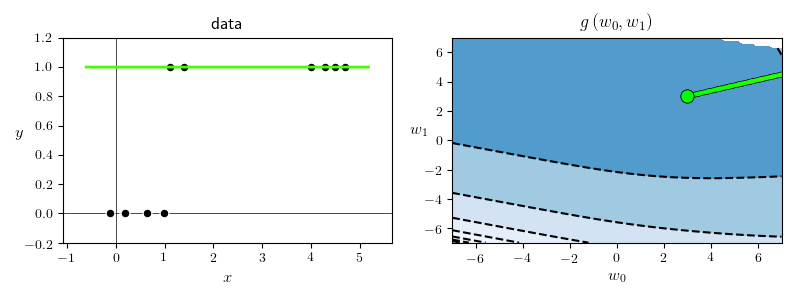
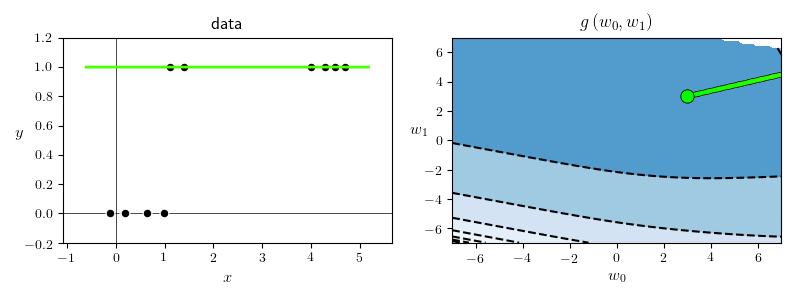
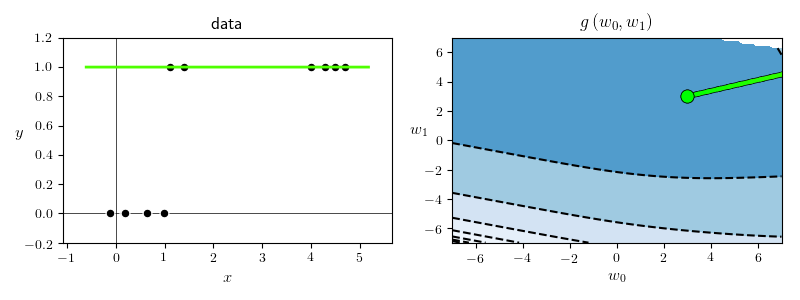
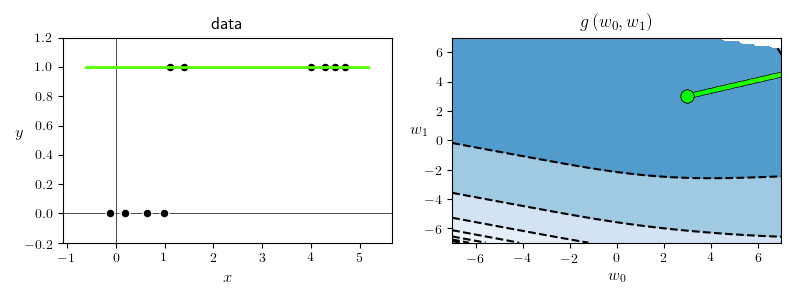
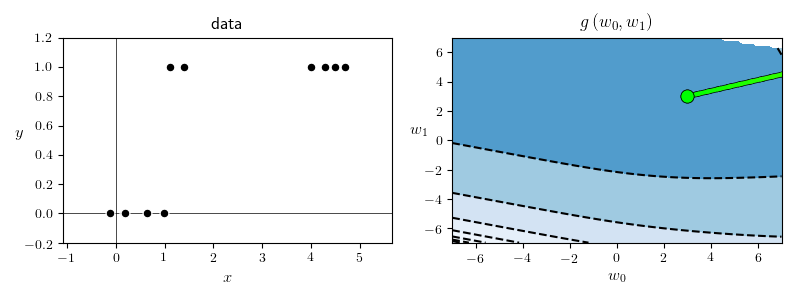
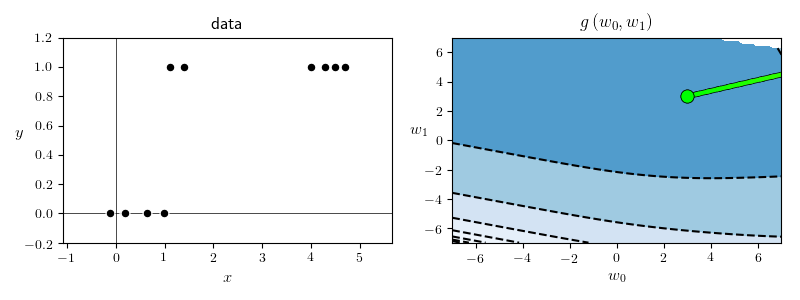
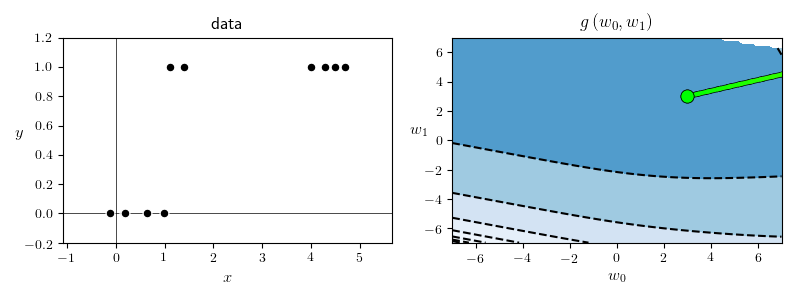
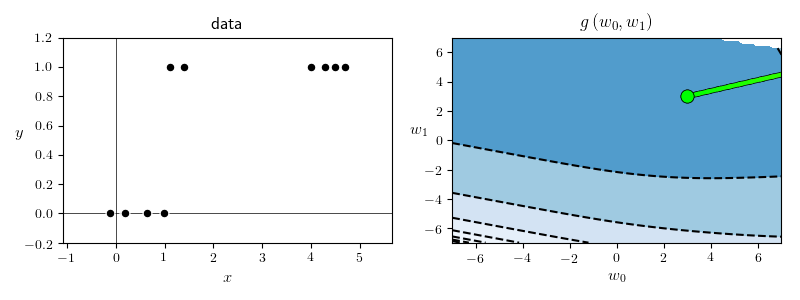
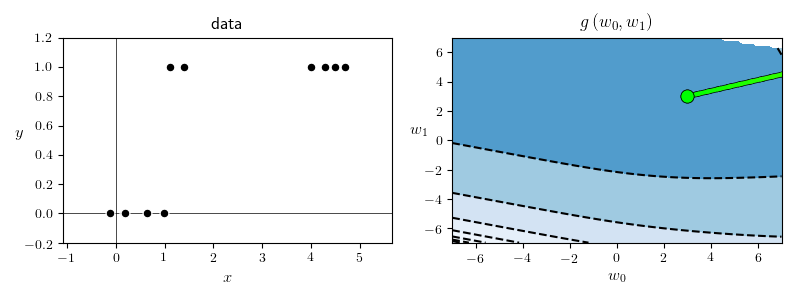
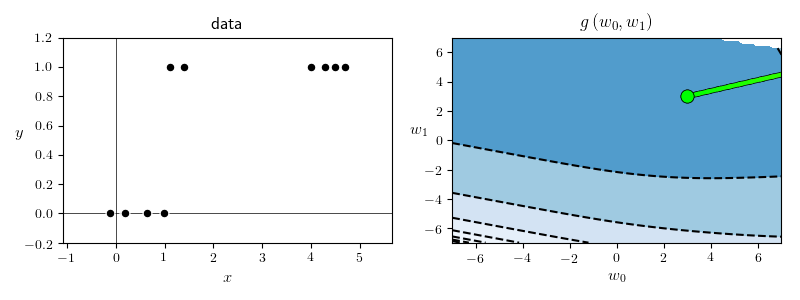
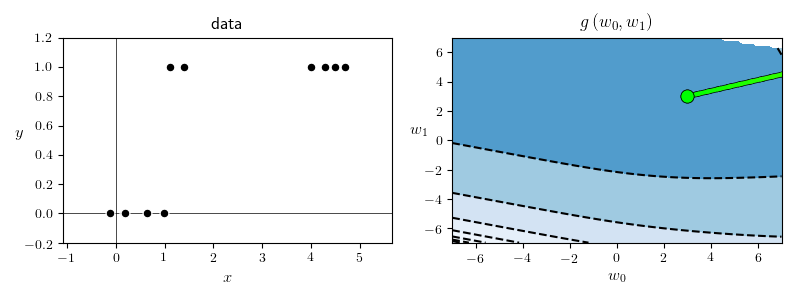
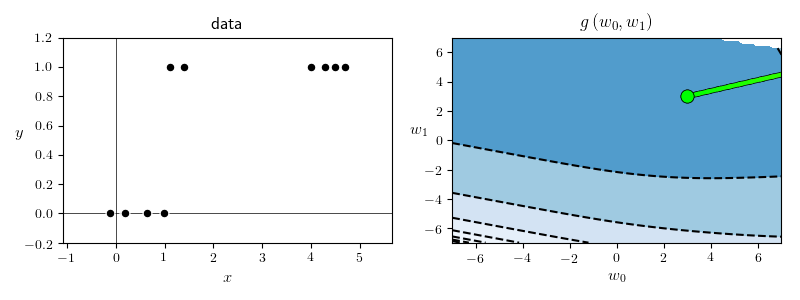
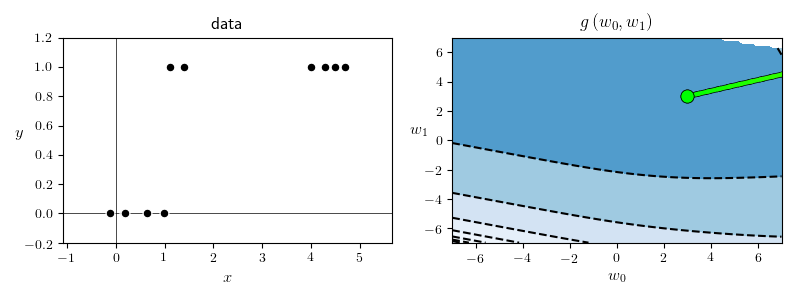
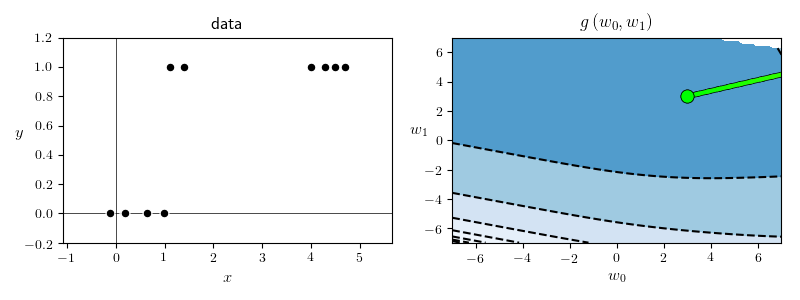
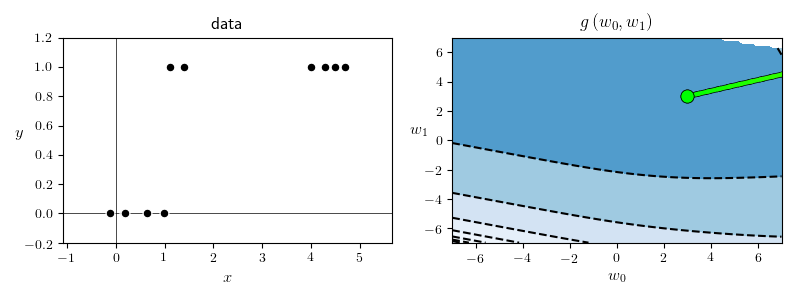
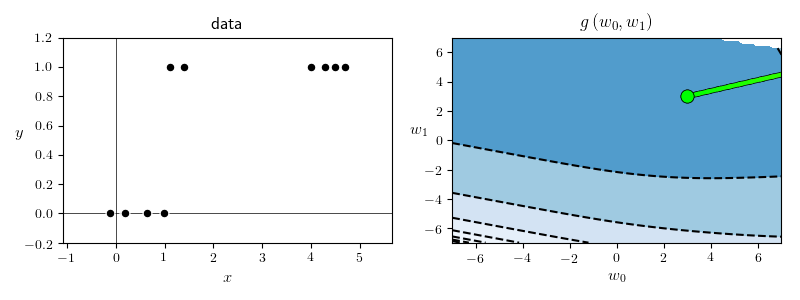
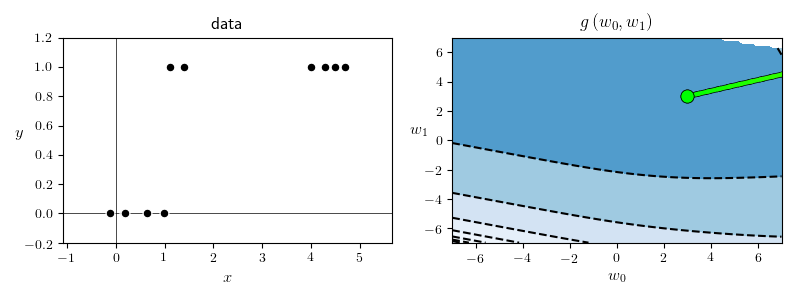
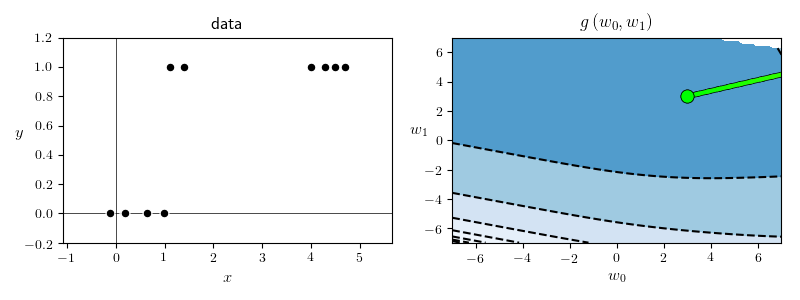
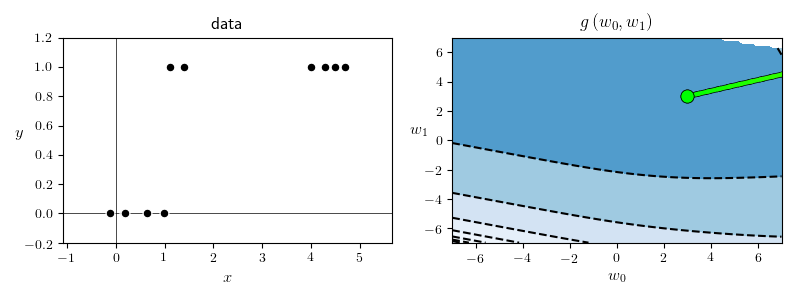
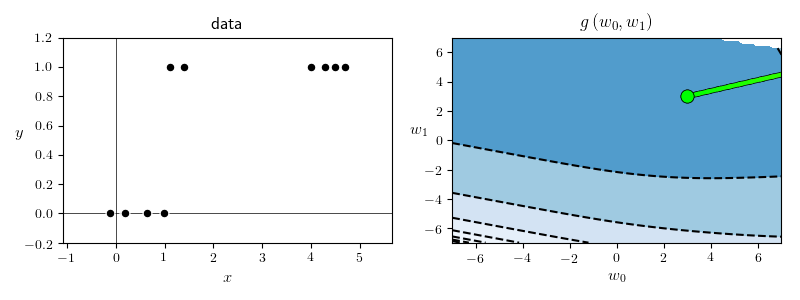
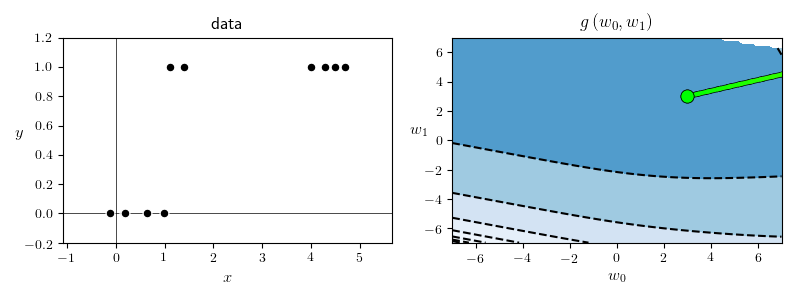
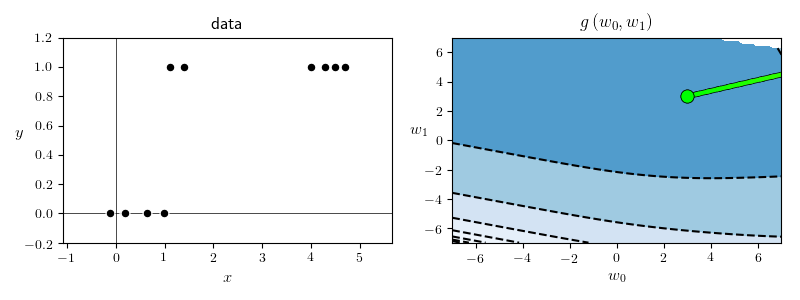
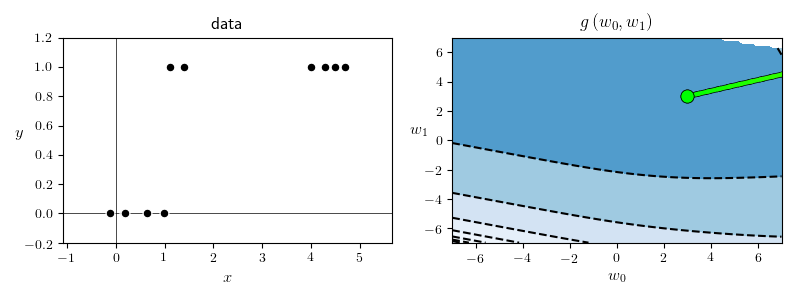
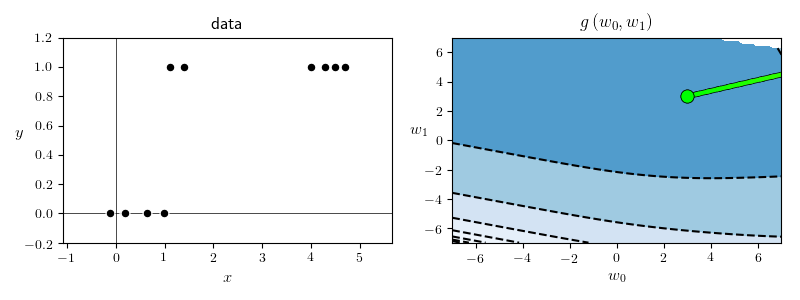
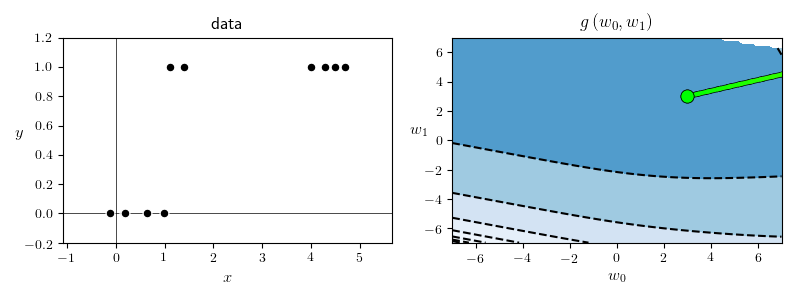
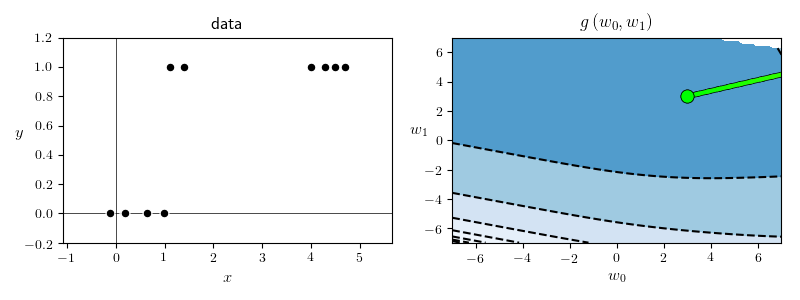
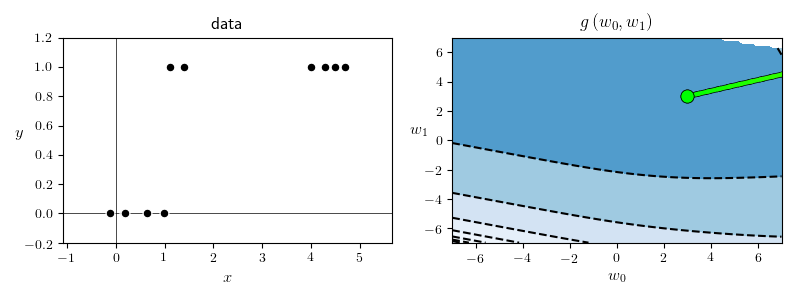
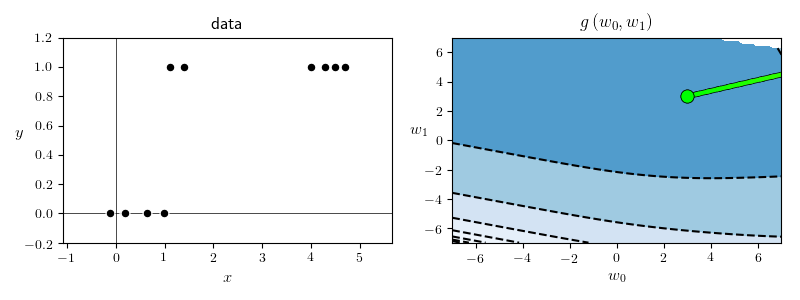
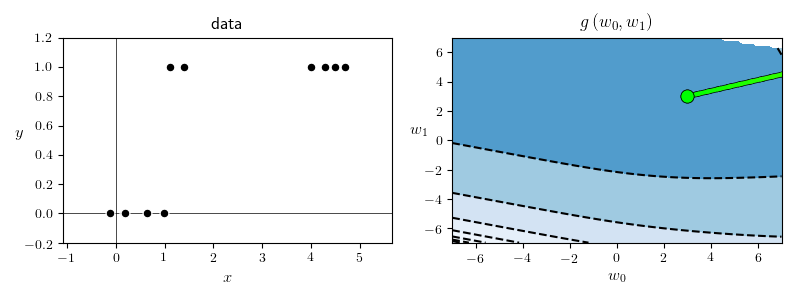
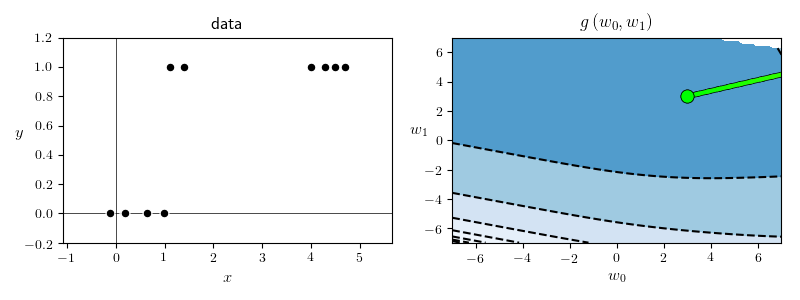
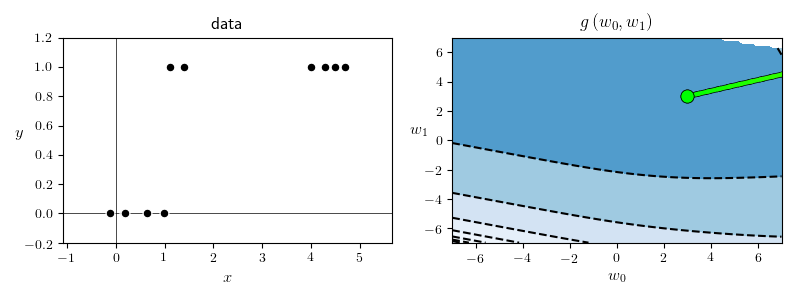
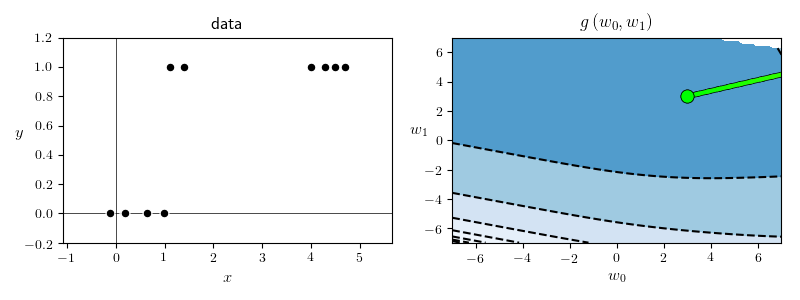
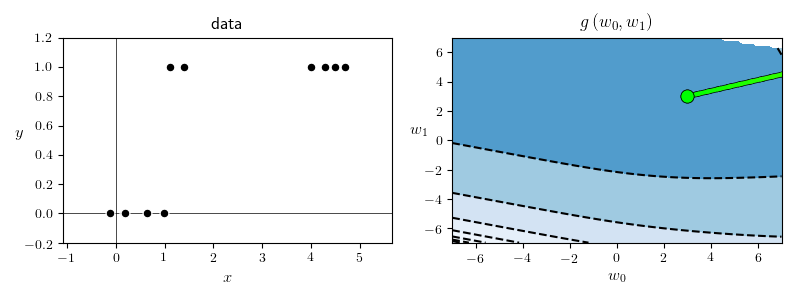
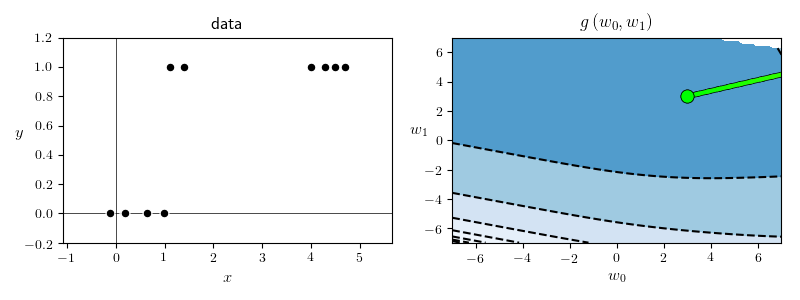
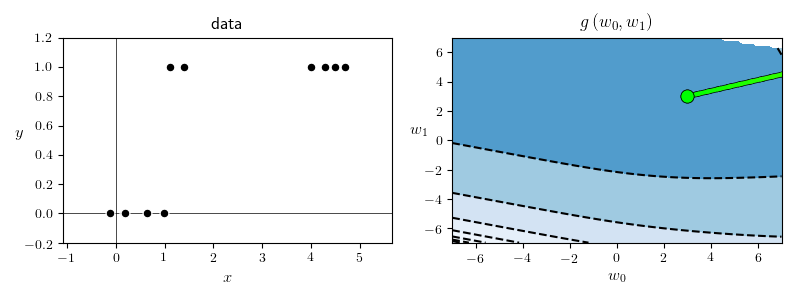
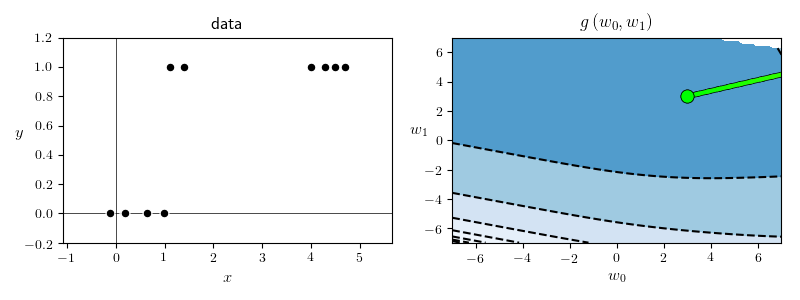
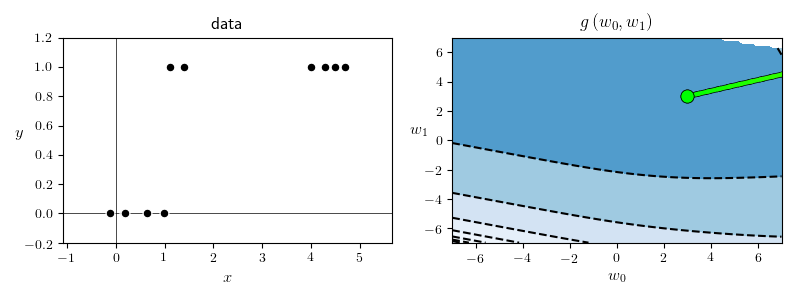
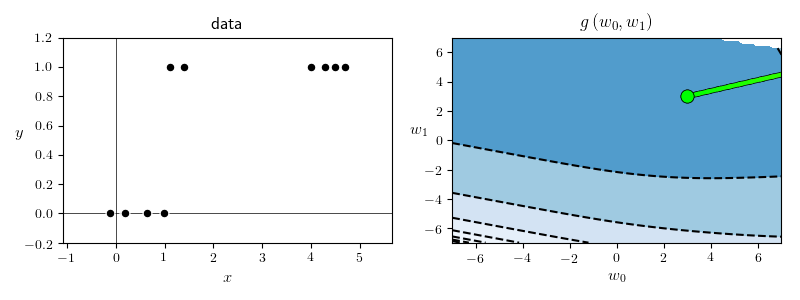
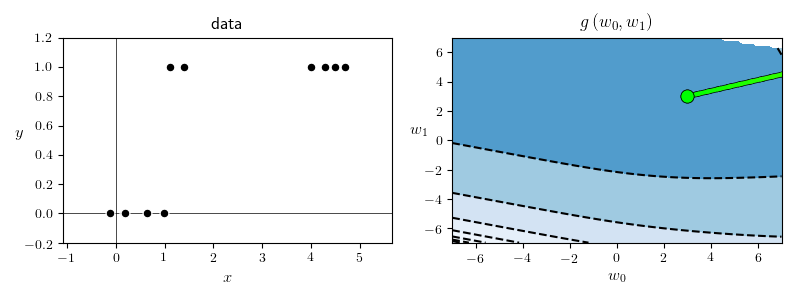
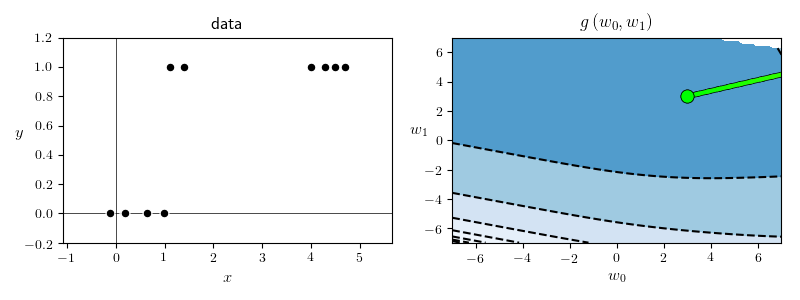
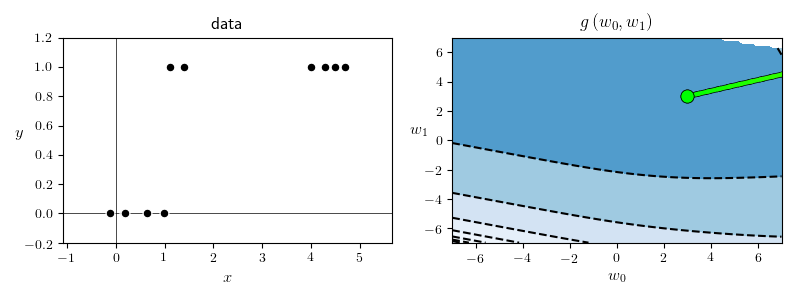
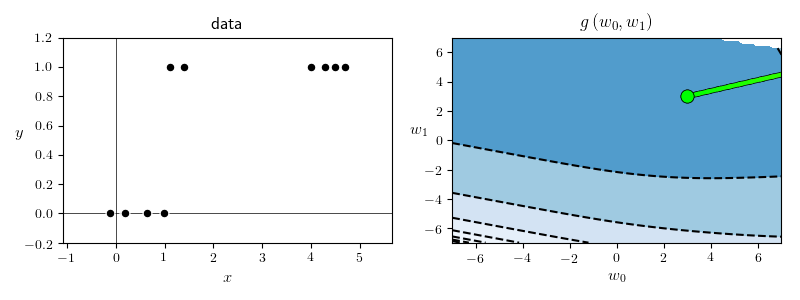
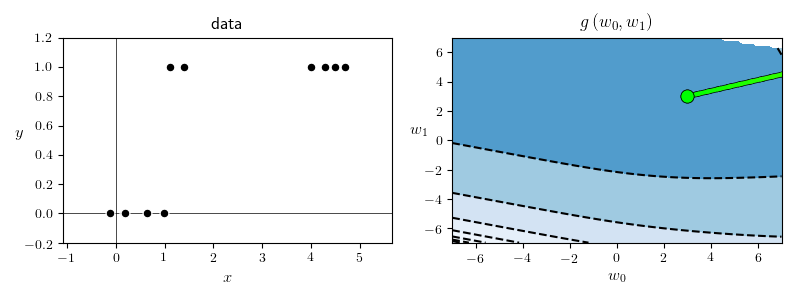
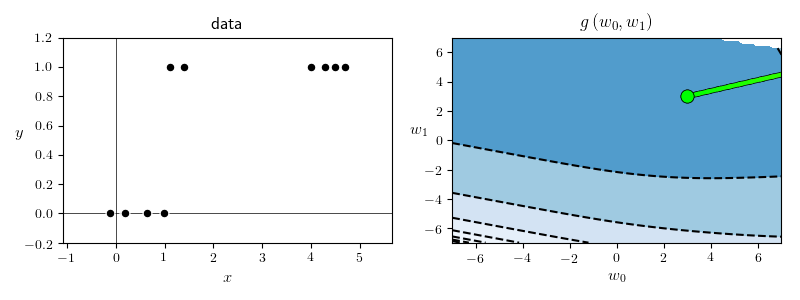
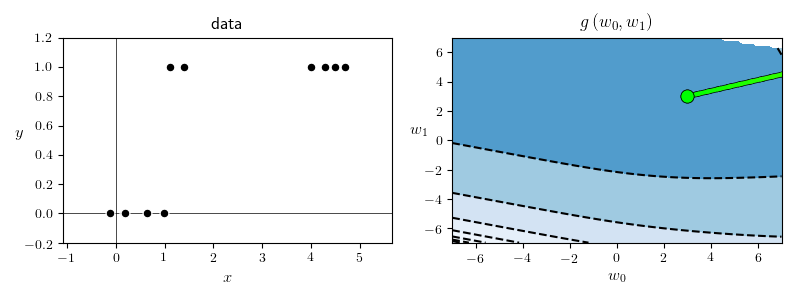
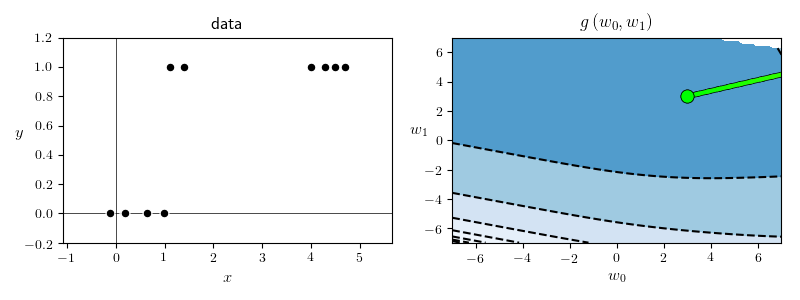
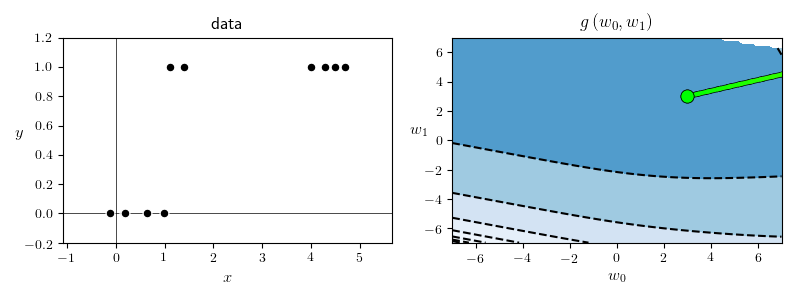
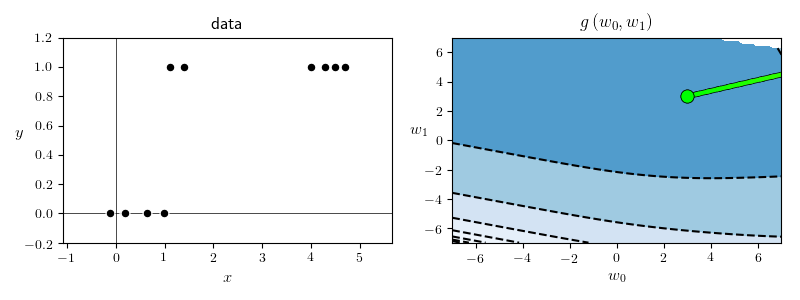
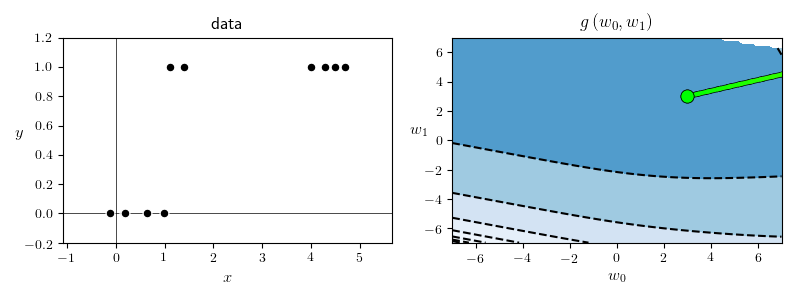
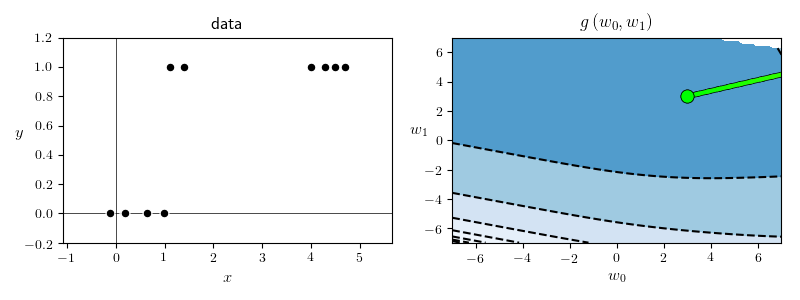
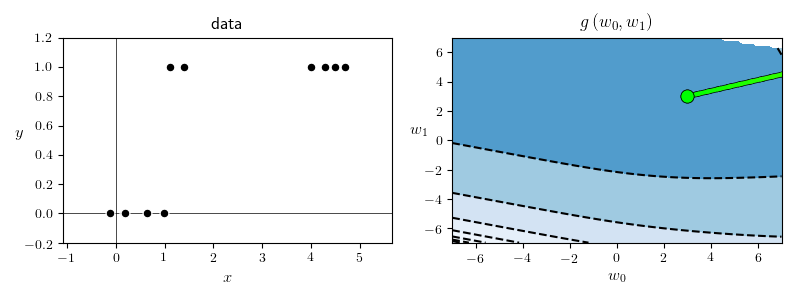
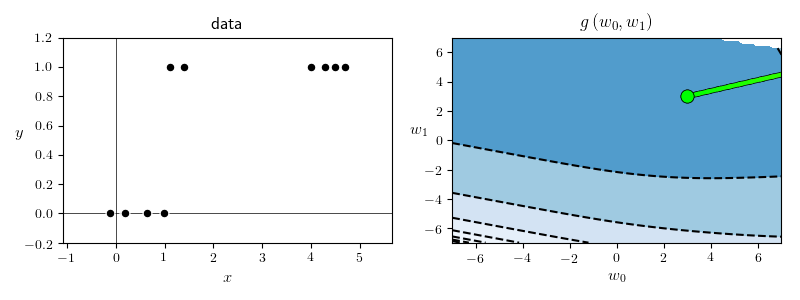
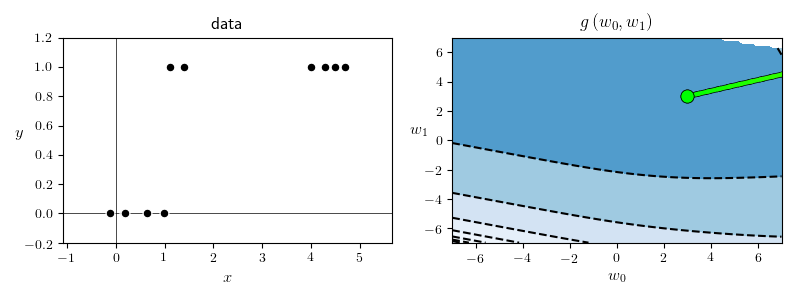
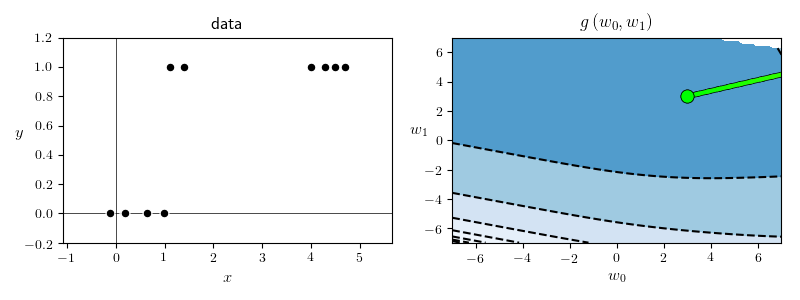
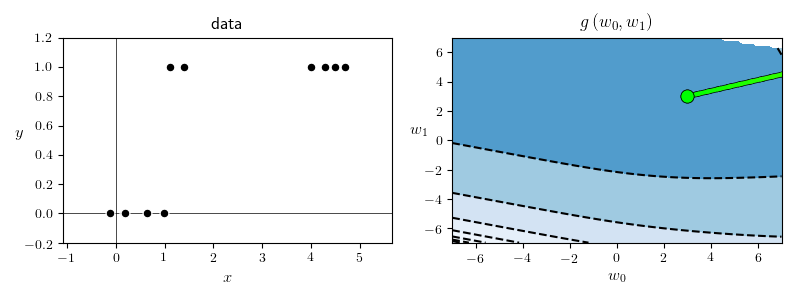
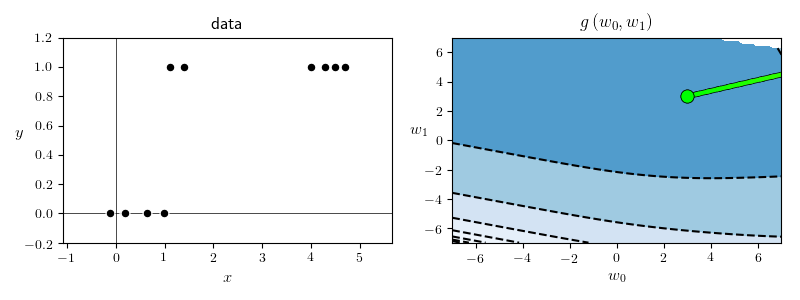
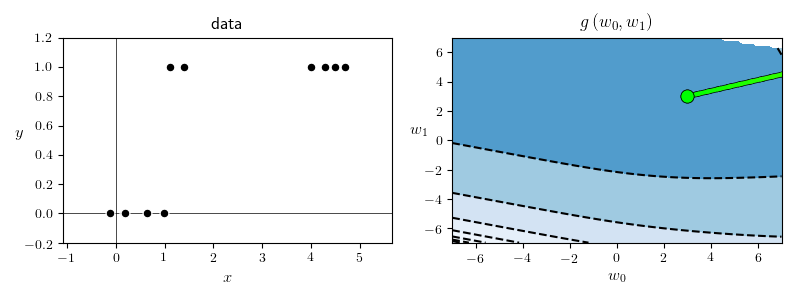
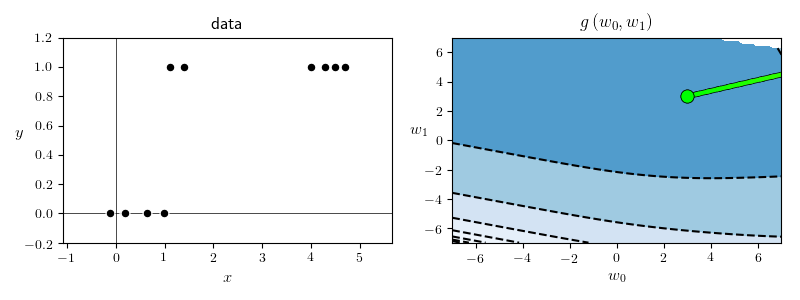
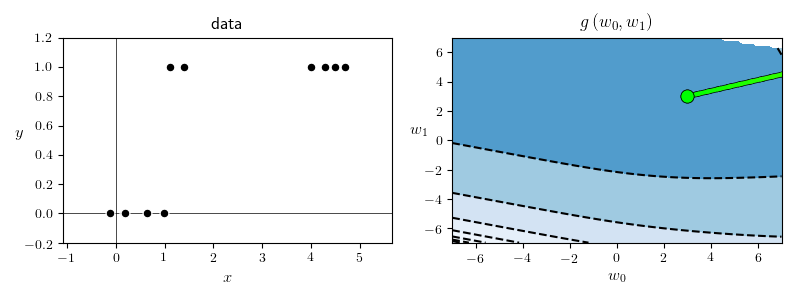
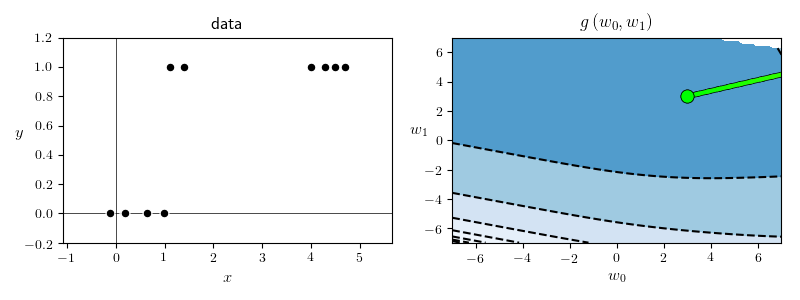
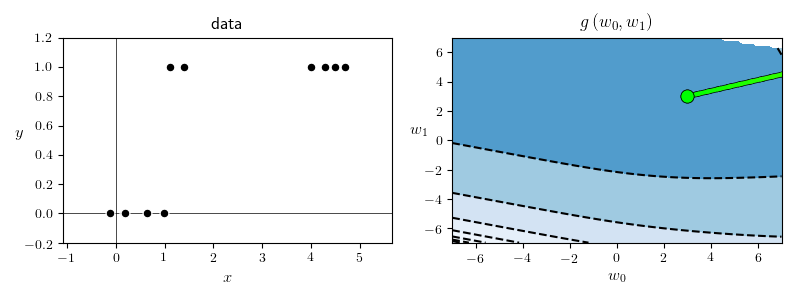
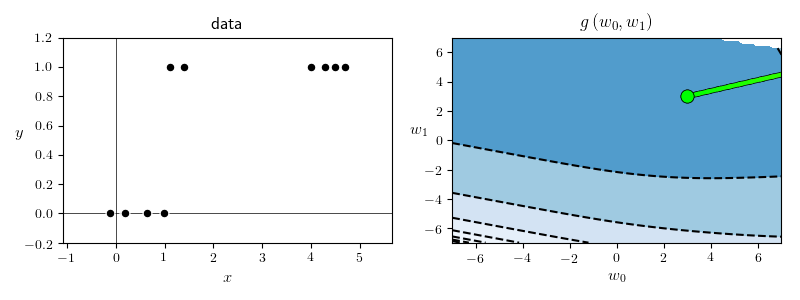
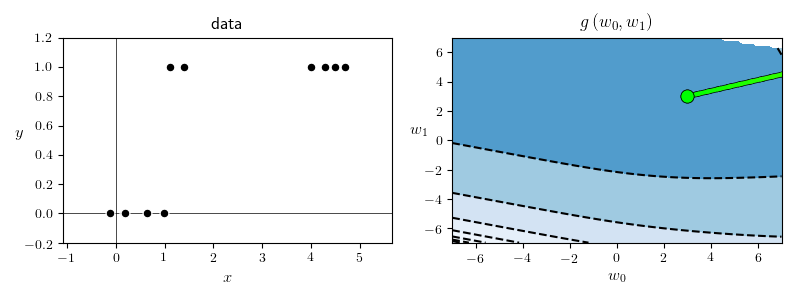
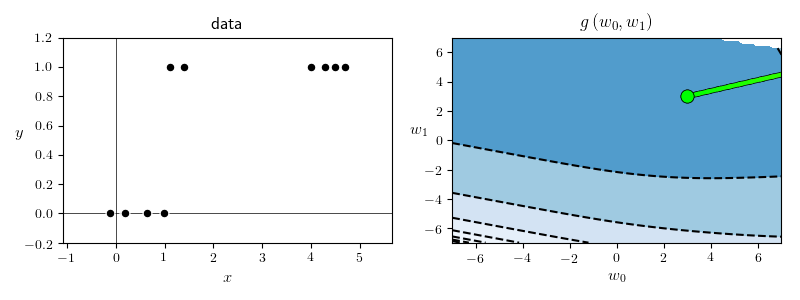
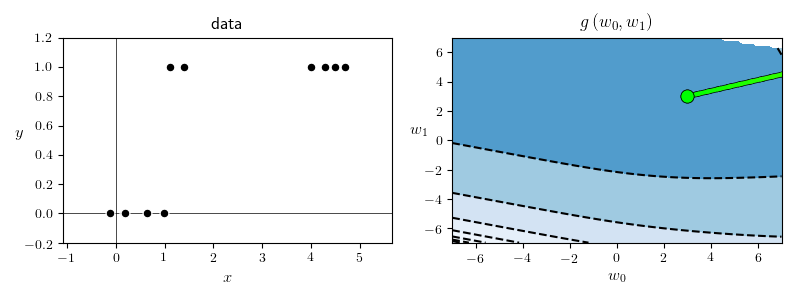
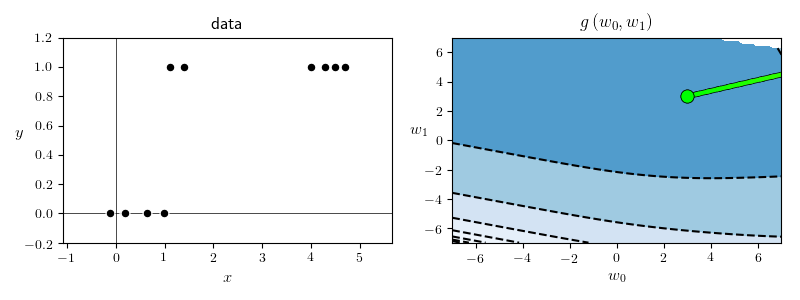
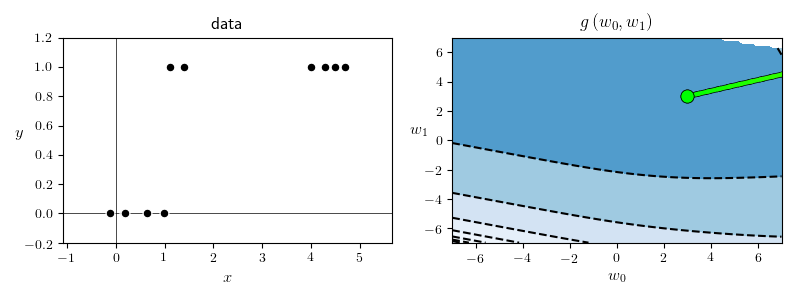
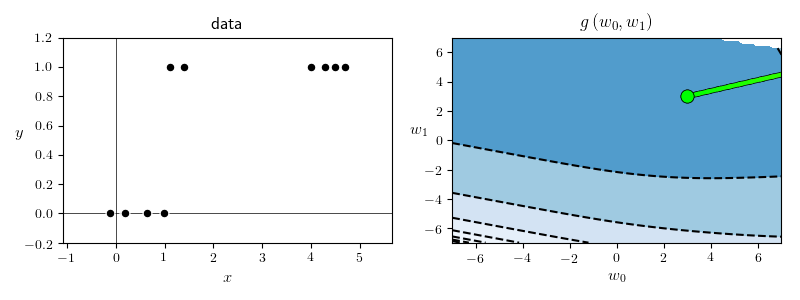
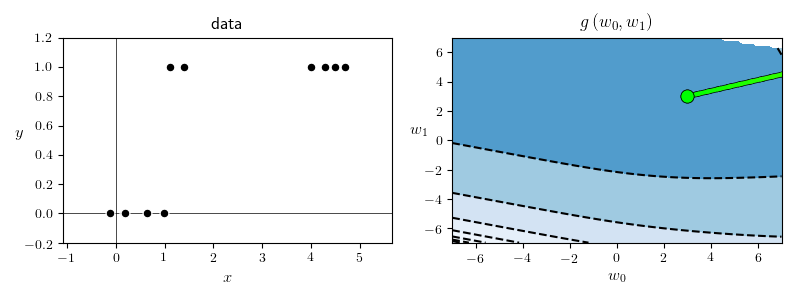
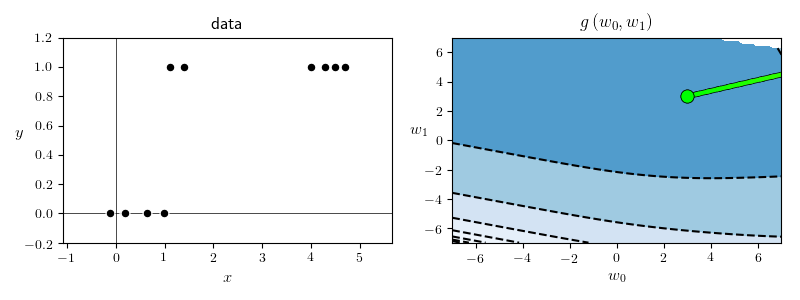
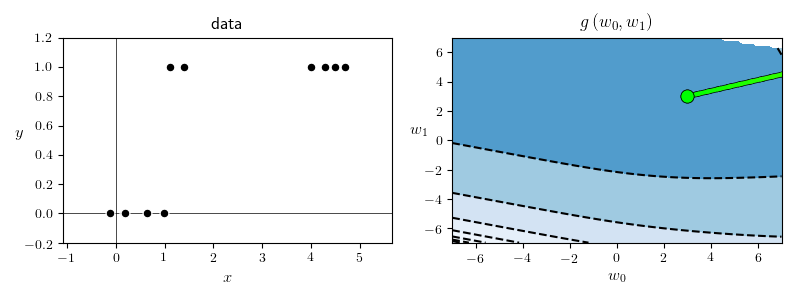
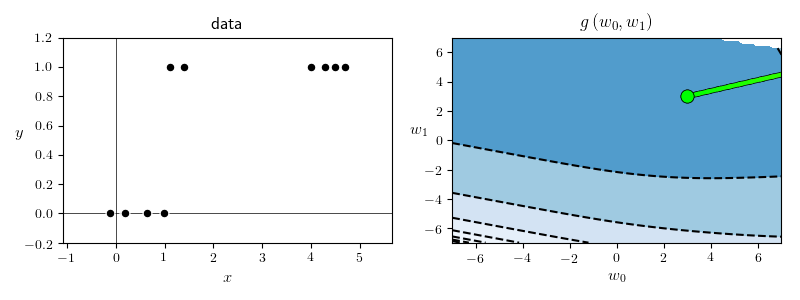
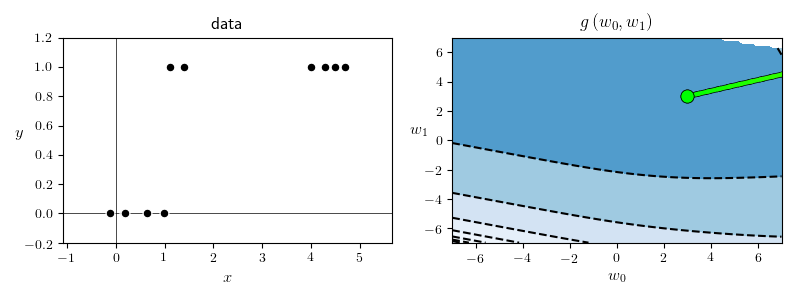
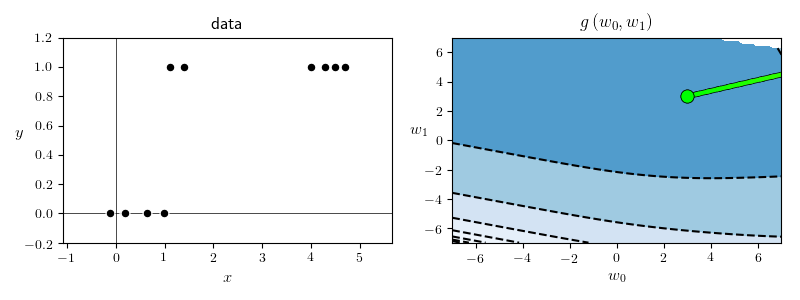
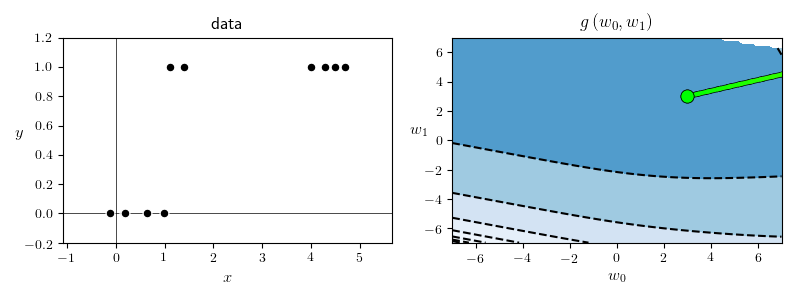
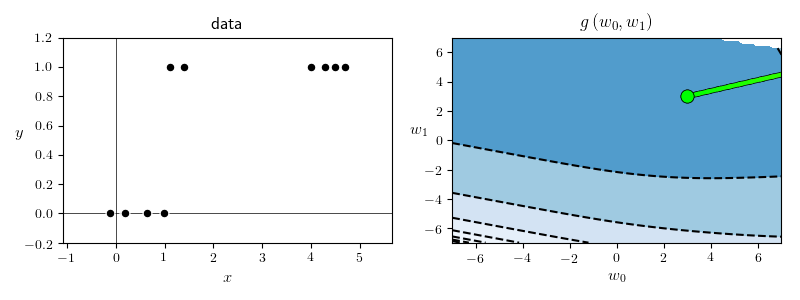
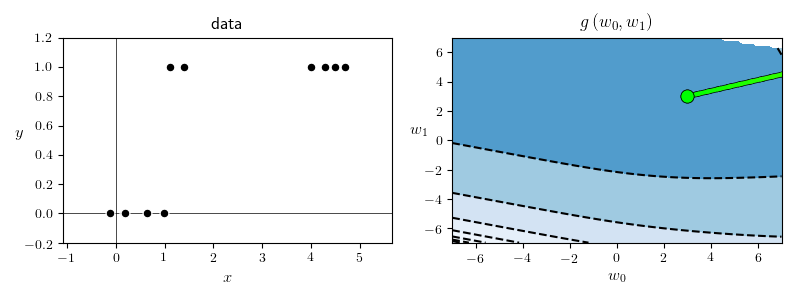
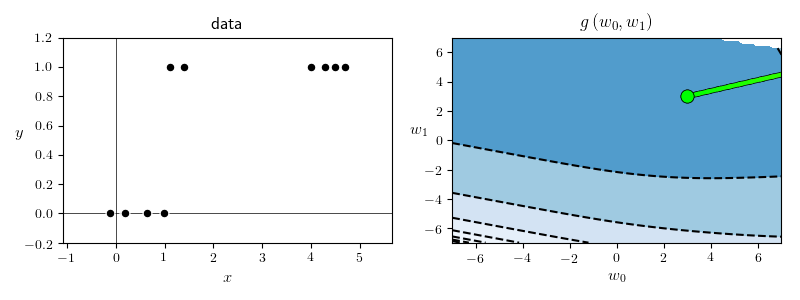
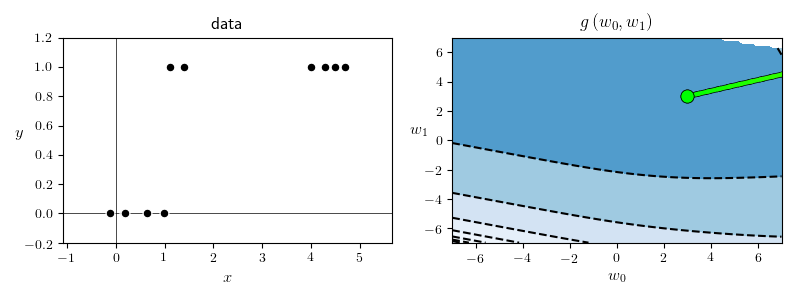
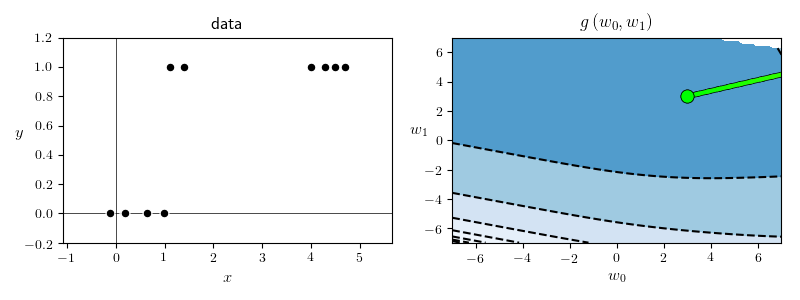
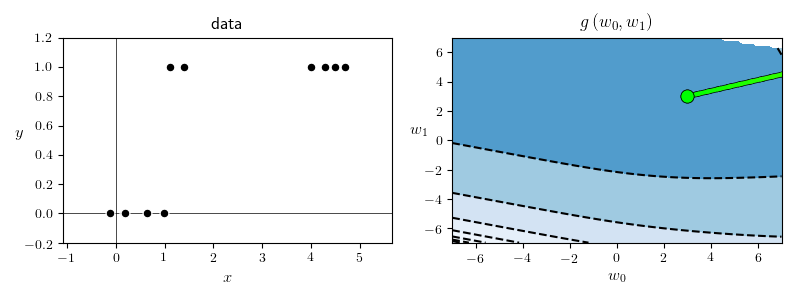
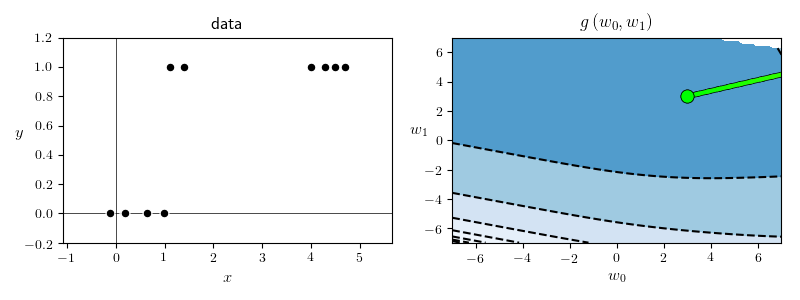
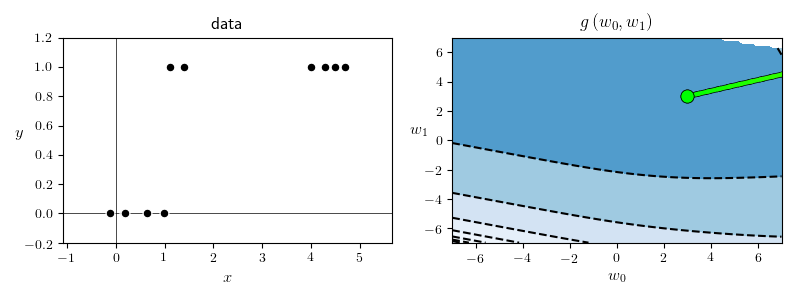
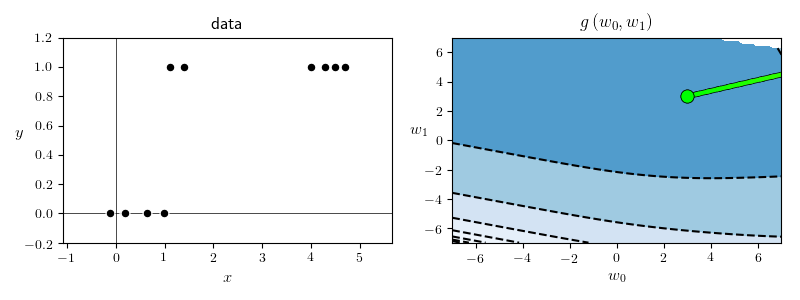
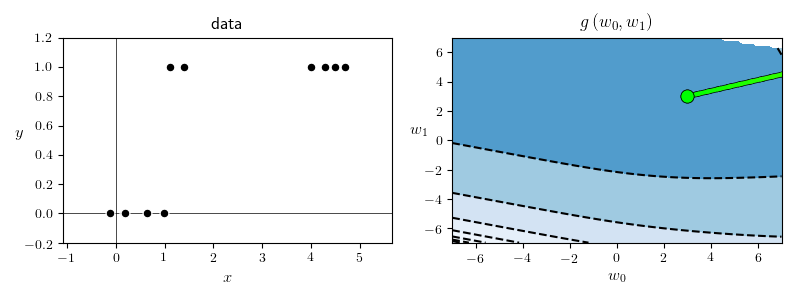
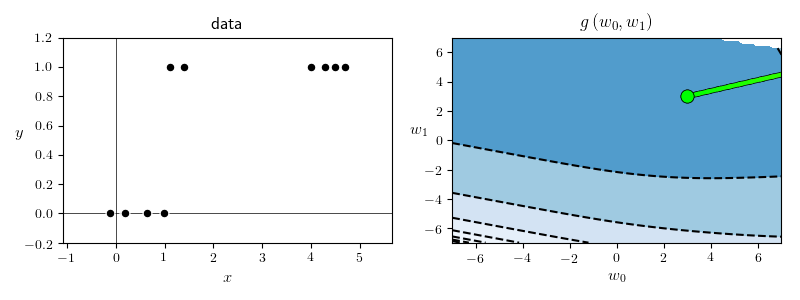
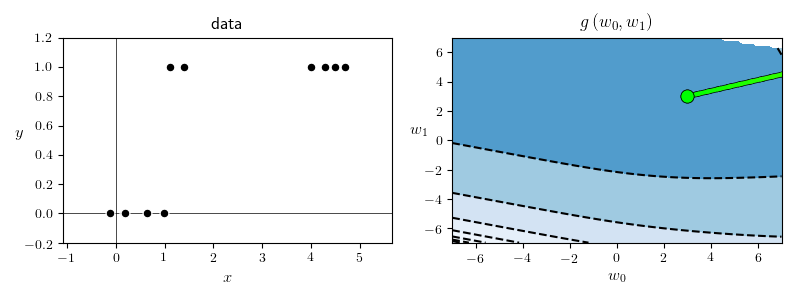
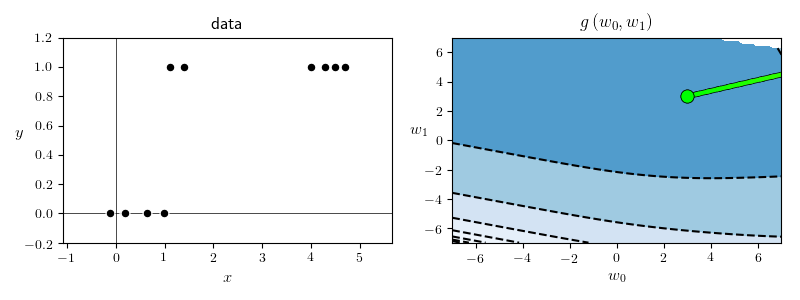

In [14]:
# This code cell will not be shown in the HTML version of this notebook
# create instance of logisic regression demo and load in data, cost function, and descent history
animator = superlearn.classification_2d_demos.Visualizer(data,g)

# animate descent process
animator.animate_run(weight_history,num_contours = 25,viewmax = 7)

Below we show the result of running gradient descent with the same initial point and fixed steplength parameter for $2000$ iterations, which results in a better fit.

<IPython.core.display.Javascript object>


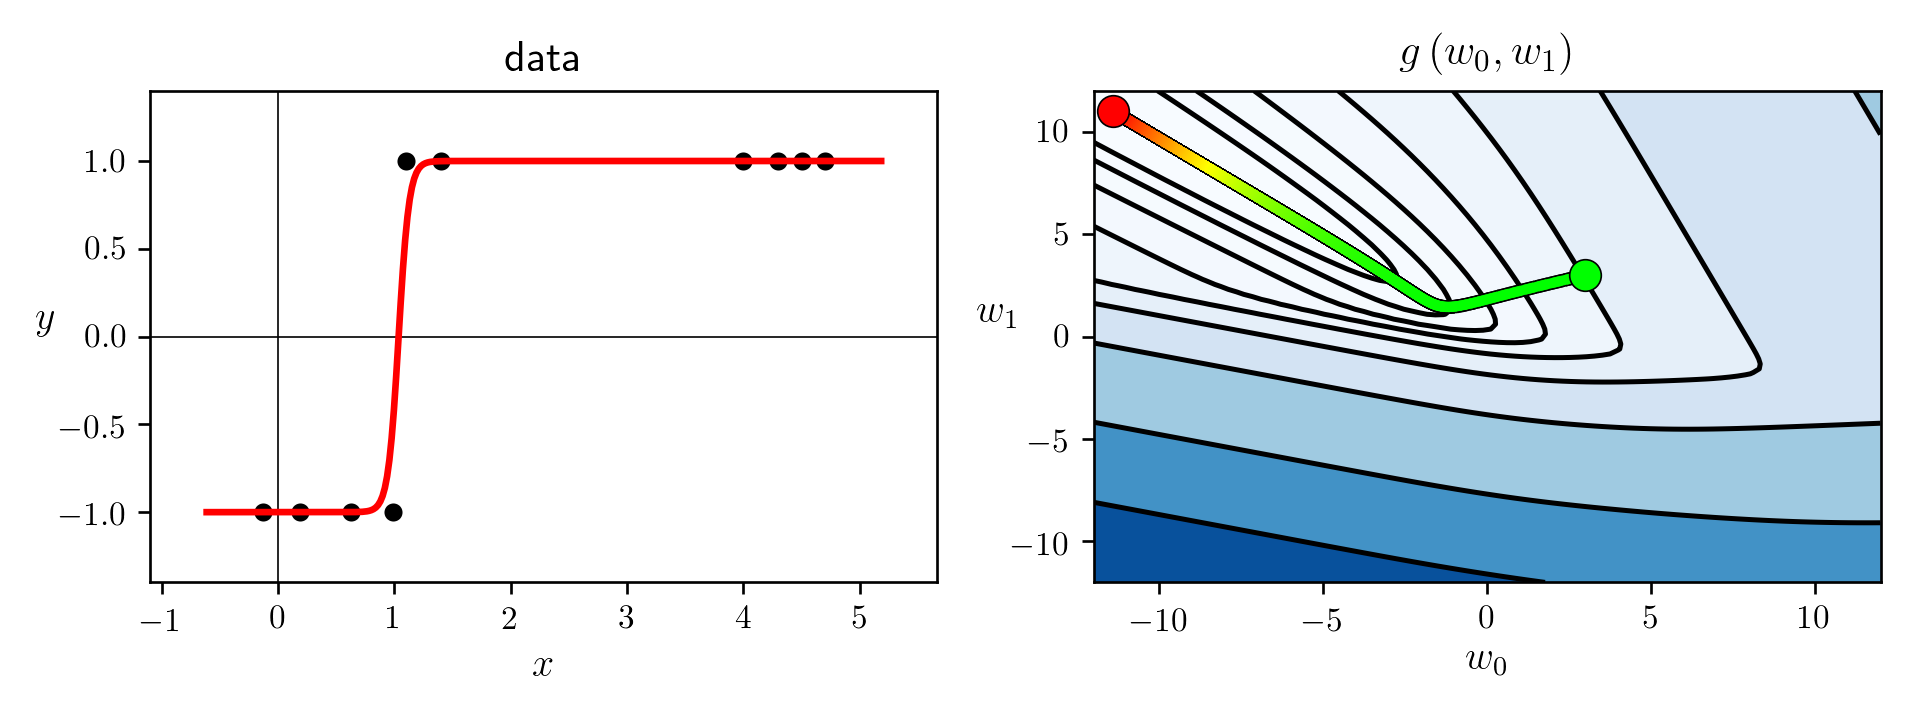

In [13]:
# This code cell will not be shown in the HTML version of this notebook
# run gradient descent to minimize the softmax cost
g = softmax; w = np.array([3.0,3.0])[:,np.newaxis]; max_its = 2000; alpha_choice = 1;
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# create a static figure illustrating gradient descent steps 
animator.static_fig(weight_history,num_contours = 25,viewmax = 12)

#### <span style="color:#a50e3e;">Example 4: </span> Using Newton's method to perform logistic regression using the softmax cost

In applying Newton's method to minimize a cost function like the softmax we must be careful not to take too many steps, as it is possible that the global minimum technically lies at infinity (this is where the tanh function perfectly resembles the sign function), and taking too many large steps towards it can lead to numerical issues as weights becomes extremely large.  Here we examine a simple instance of this behavior using the single input dataset shown in the first subsection above.  

Newton's method can also be used to minimize the softmax cost in this instance, taking large steps moving towards infinity. In this example we illustrate the progress of 5 Newton steps beginning at the point $\mathbf{w} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$.  Within 5 steps we have reached a point providing a very good fit to the data.  If we take many more steps than shown here we will travel very far out in the input space of the function.

<IPython.core.display.Javascript object>


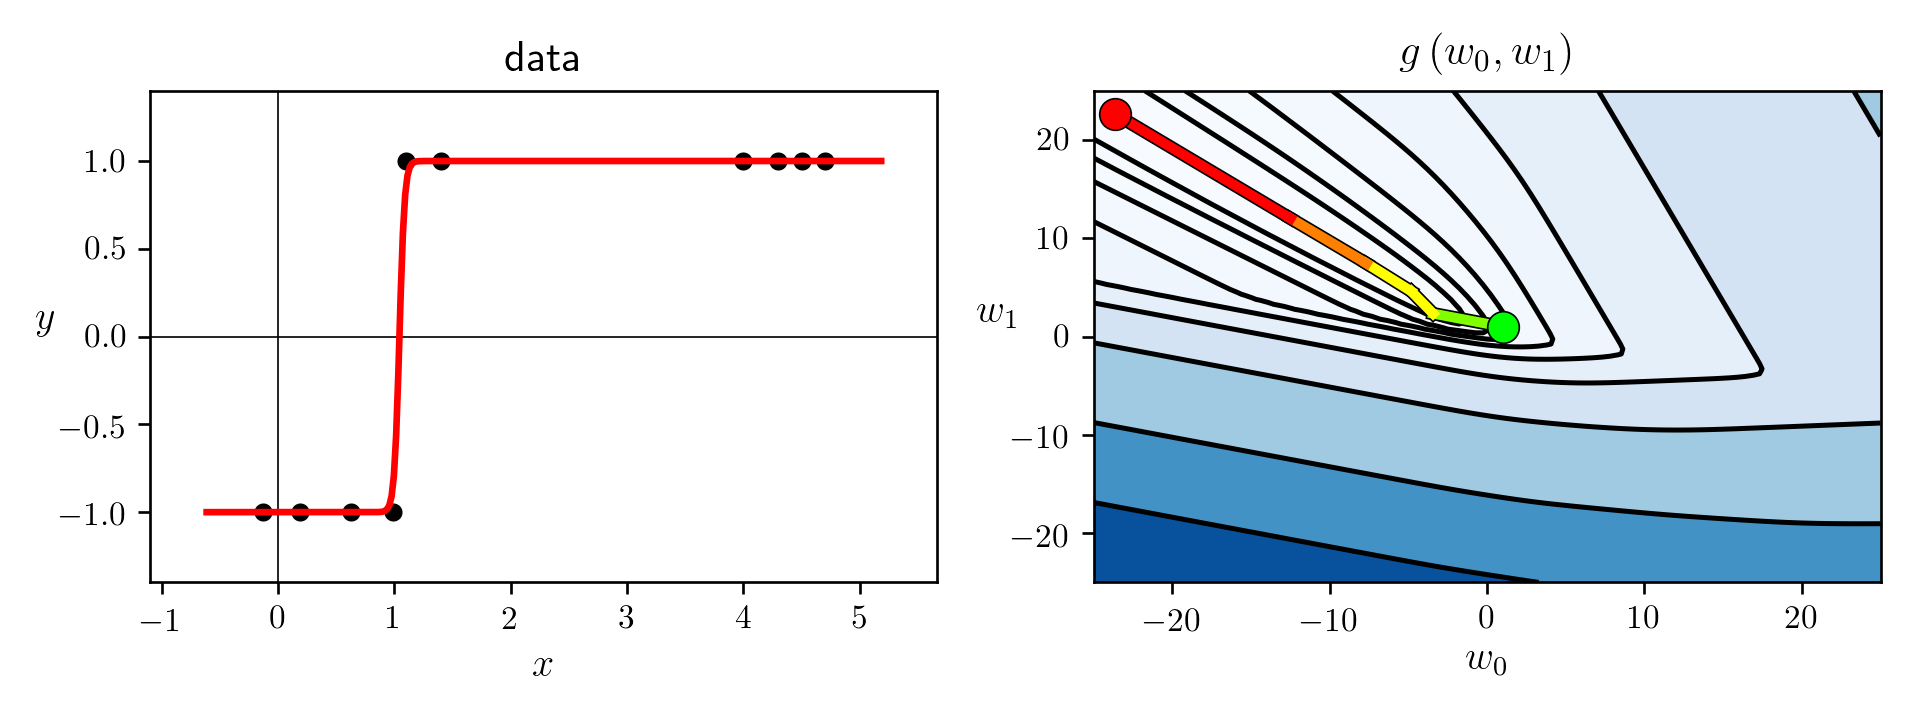

In [26]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
data = np.loadtxt(datapath + '2d_classification_data_v1.csv',delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# run gradient descent to minimize the softmax cost
g = softmax; w = np.ones((2,1)); max_its = 5;
weight_history,cost_history = optimizers.newtons_method(g,max_its,w,epsilon = 10**(-7))

# create a static figure illustrating gradient descent steps 
animator.static_fig(weight_history,num_contours = 25,viewmax = 25)

Notice that if we simply flip one of the labels - making this dataset not perfectly linearly separable - the corresponding cost function does not have a global minimum out at infinity, as illustrated below.

<IPython.core.display.Javascript object>


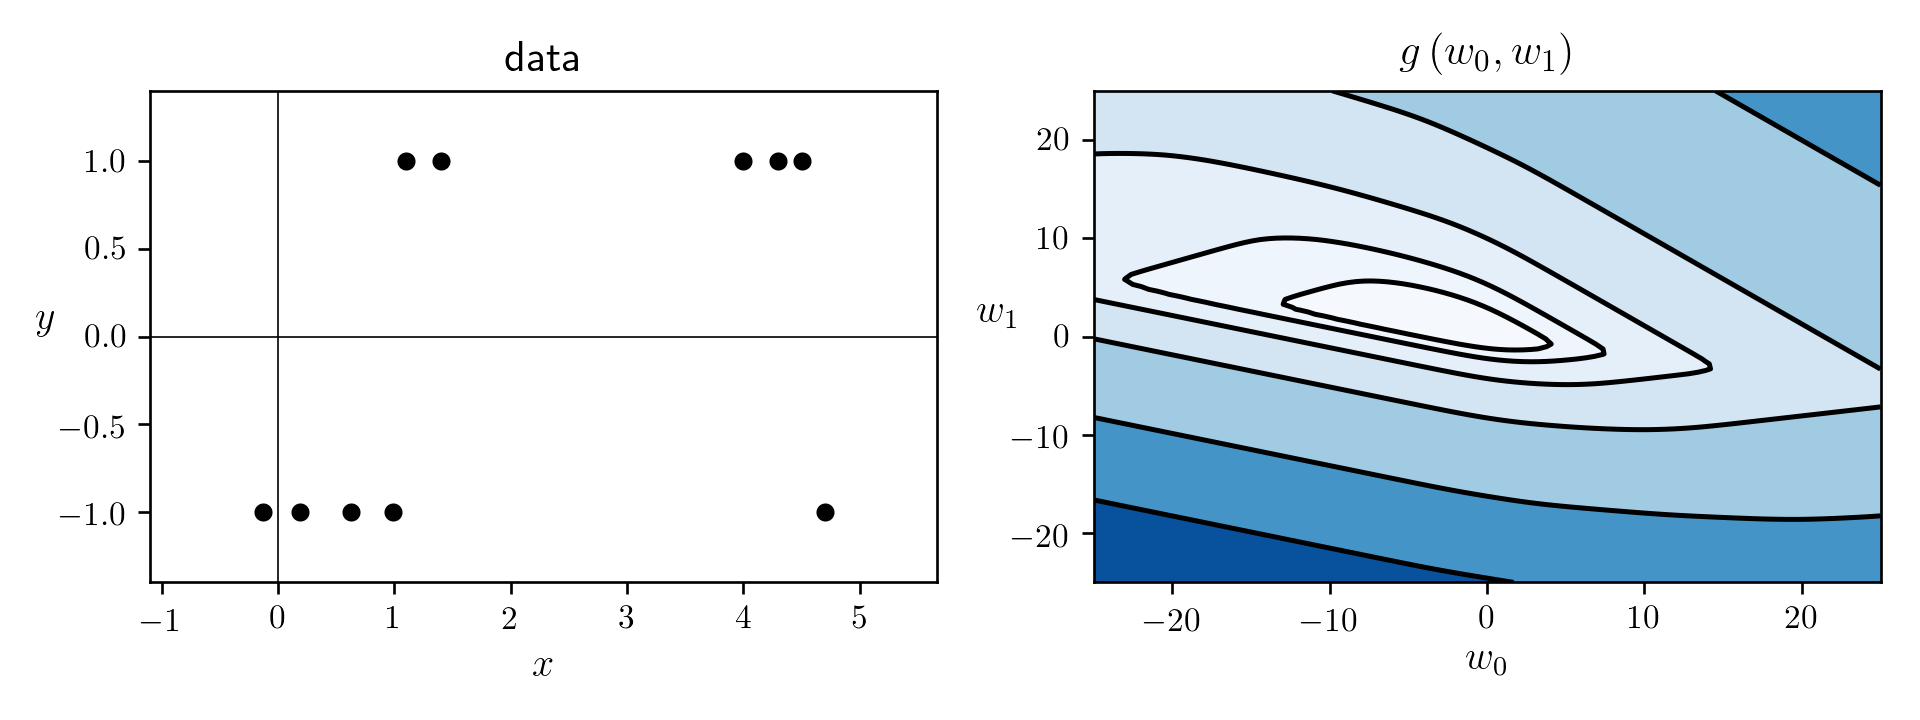

In [39]:
# This code cell will not be shown in the HTML version of this notebook
# switch a label
y[0,-1] = -1
data = np.vstack((x,y))

# draw contour of this new data
animator = superlearn.classification_2d_demos.Visualizer(data,softmax)

# create a static figure illustrating gradient descent steps 
animator.static_fig([],num_contours = 15,viewmax = 25)

## 9.1.6  'Noisy' datasets

Below we load in and plot a multi-input ($N = 2$) dataset that has 100 points, and whose two classes cannot be perfectly separated by any line (and consequently whose points cannot be perfectly fit using a tanh or even sign function).  In the left panel we show the data in three dimensions, and in the right panel we show the data from above in the 'separator' view.  

<IPython.core.display.Javascript object>


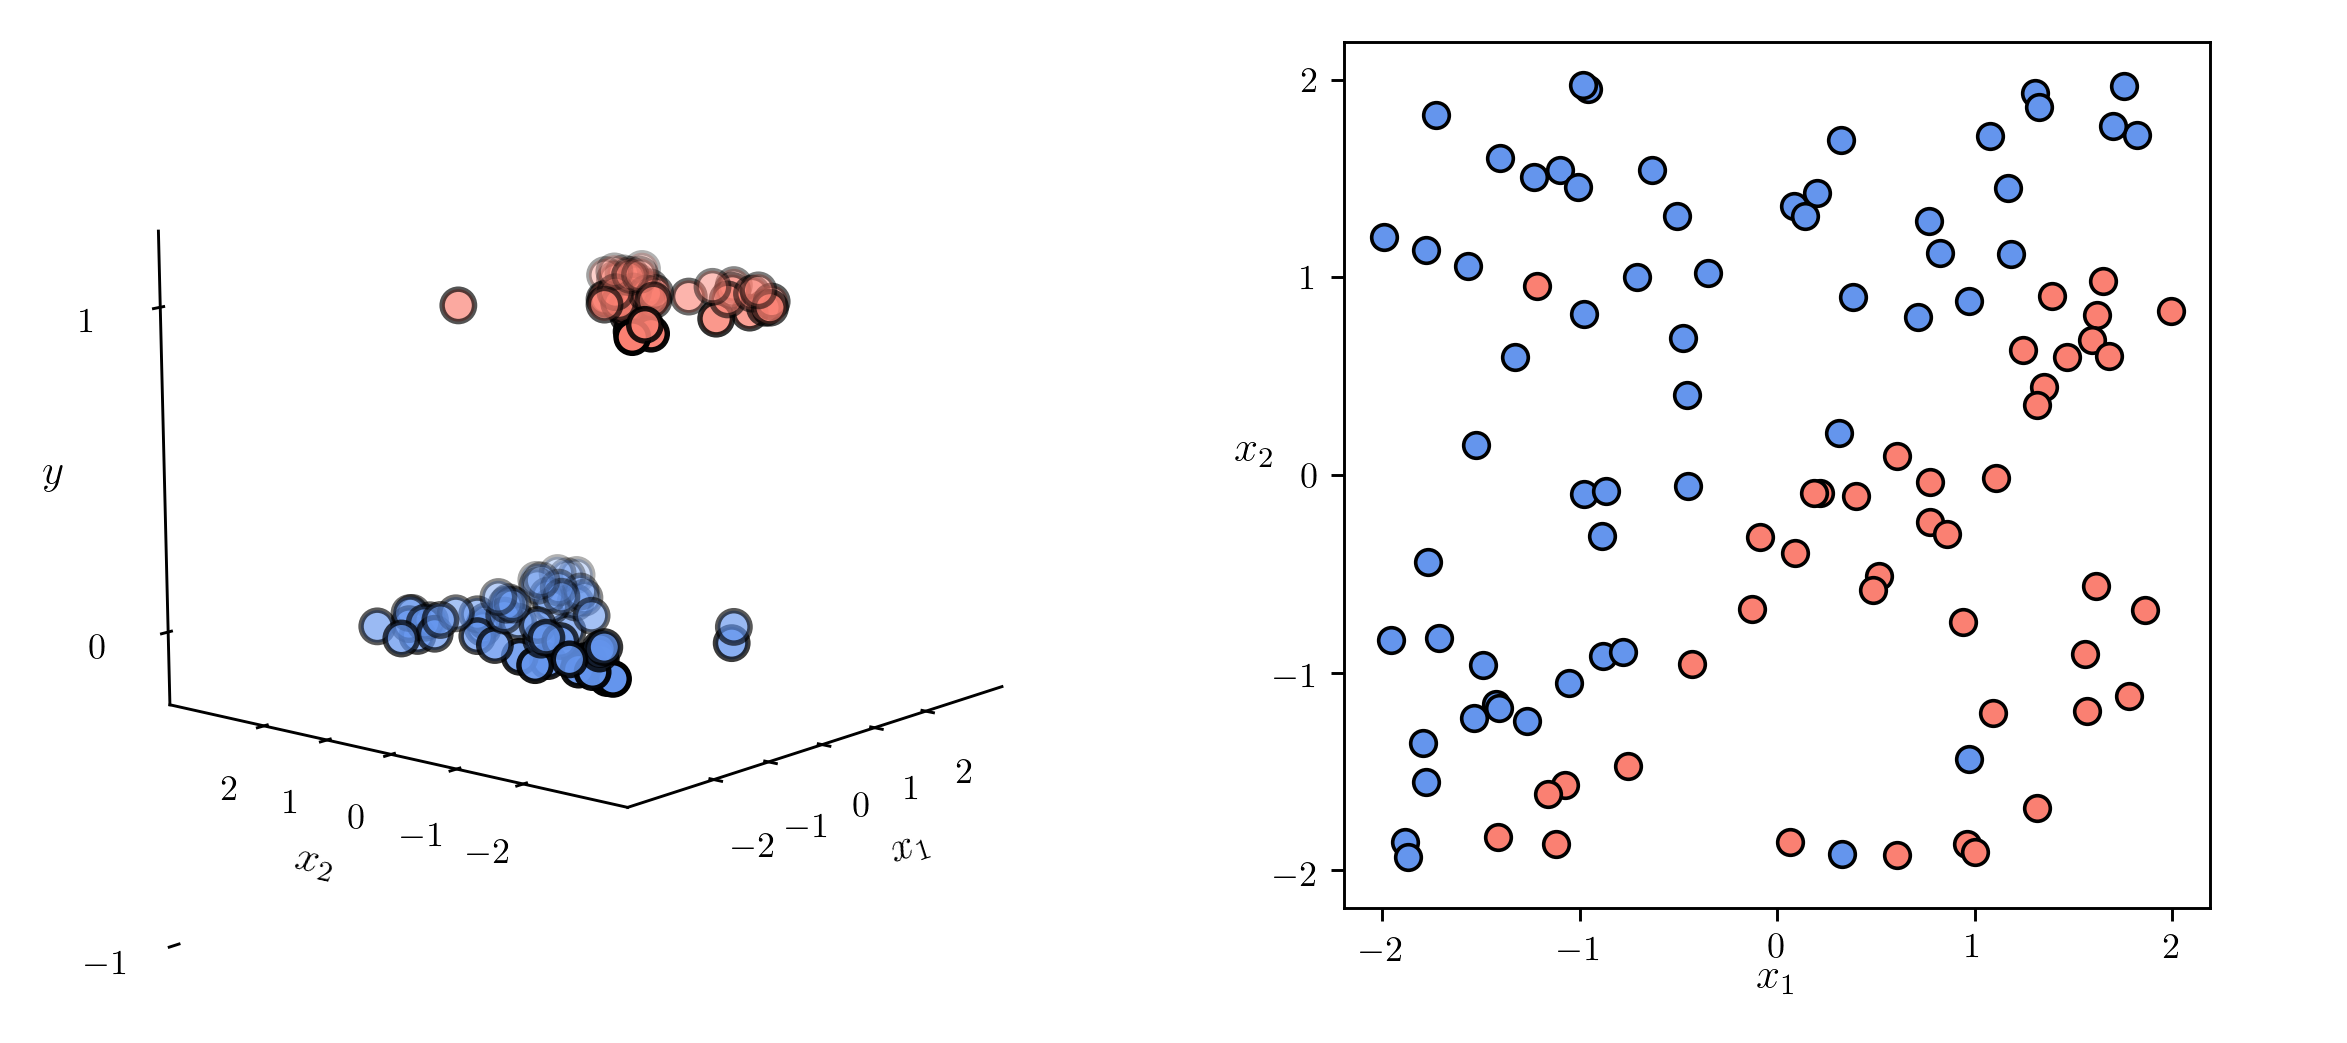

In [20]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
data = np.loadtxt(datapath + '3d_classification_data_v0_entropy.csv',delimiter = ',')

# create instance of linear regression demo, used below and in the next examples
demo = superlearn.classification_3d_demos.Visualizer(data)

# plot data
demo.plot_data(view = [15,-140])

As you can see, there are three points here (two blue points and one red points) that look like they are on 'the wrong side'. Other than these 'noisy' points the two classes look like they can be very well fit with our nonlinear regressor $\text{tanh}\left(w_0 + w_1x_1 + w_2x_2\right)$ in the left panel and at the same time separated by the line $w_0 + w_1x_1 + w_2x_2 = 0$ in the right panel - provided the weights are tuned properly.  Note: in the classification context a 'noisy' point is one that has an incorrect label.  Two class classification datasets typically have noise of this kind (just as we saw linear regression datasets have their own version of noise) and are not perfectly separable by a hyperplane.

> In the context of classification a 'noisy' point is one that has an incorrect label.  Two class classification datasets typically have noise of this kind (just as we saw linear regression datasets have their own version of noise) and are not perfectly separable by a hyperplane.

Even with the presence of noise we can still find the best parameters of a linear separator for a dataset like this by minimizing the softmax cost.  In the next ``Python`` cell we run $100$ steps of gradient descent with a random initialization and fixed steplenth $\alpha = 1$ to minimize the softmax cost on this dataset.

To ensure this is a proper steplength value we check the cost function history plot below.

<IPython.core.display.Javascript object>


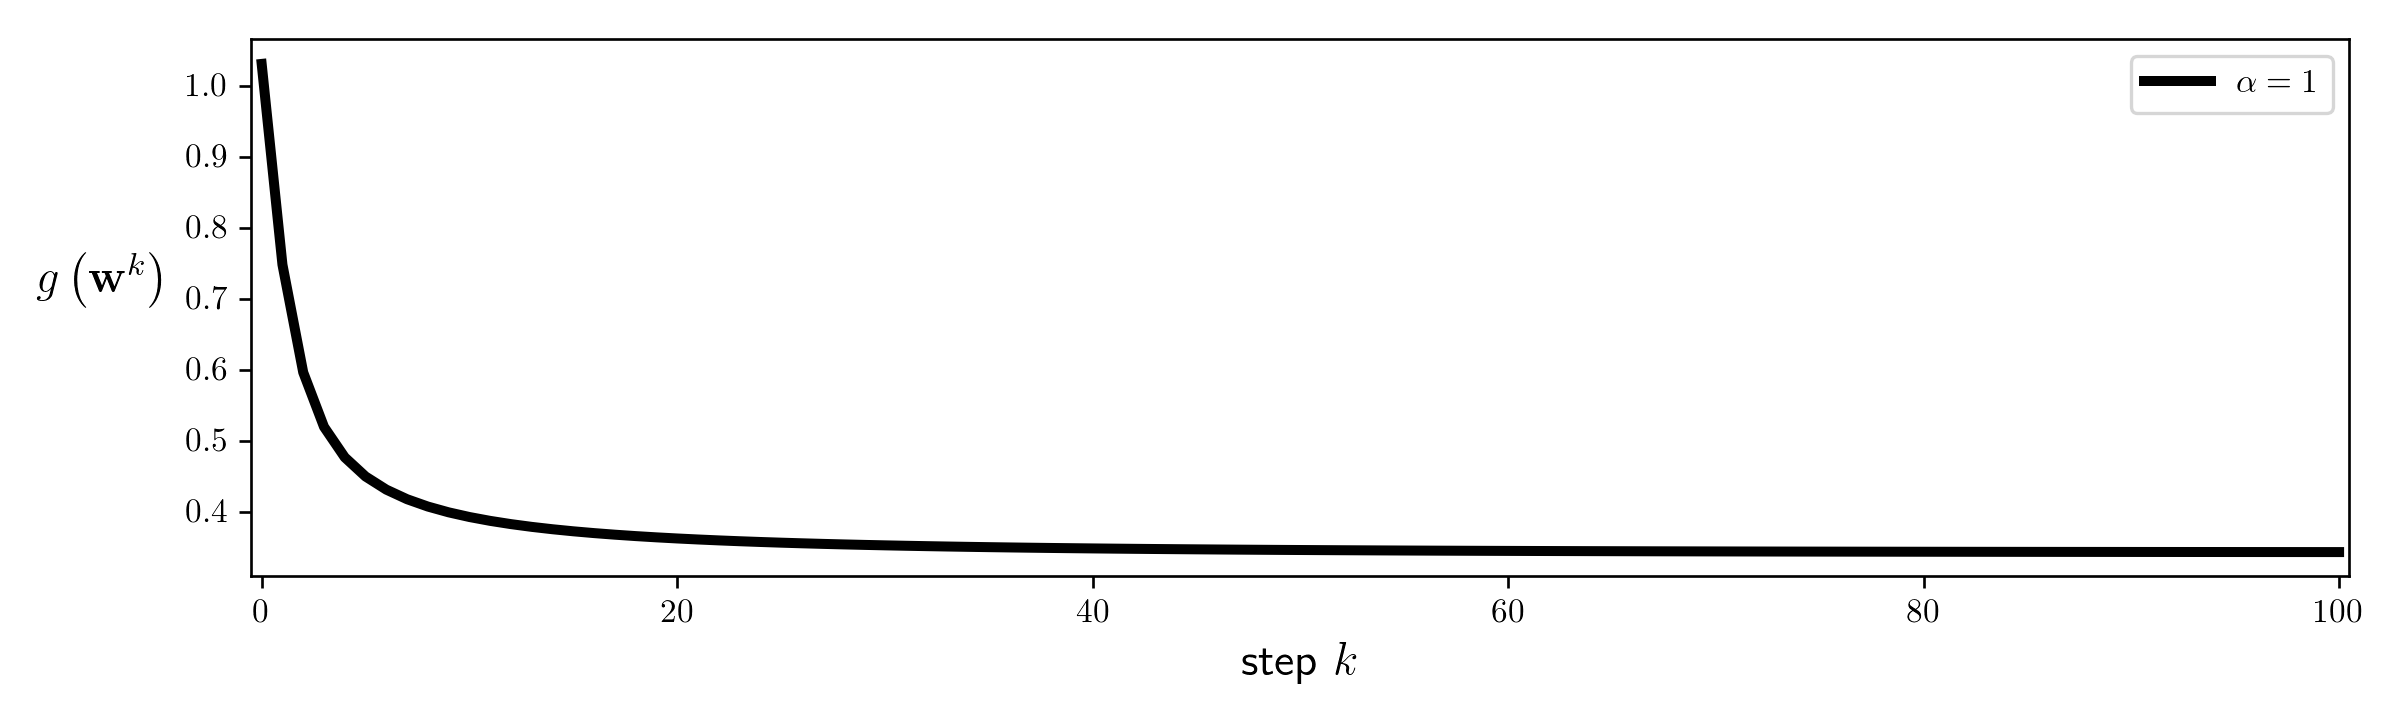

In [19]:
# This code cell will not be shown in the HTML version of this notebook
# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# run gradient descent to minimize the softmax cost
g = softmax; w = np.random.randn(3,1); max_its = 100; alpha_choice = 1;
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history],start = 0,points = False,labels = [r'$\alpha = 1$'])

In the next ``Python`` cell we plot the trained logistic function. In the left panel the dataset is shown in three dimensions, along with tanh surface fit. We also show draw the separator or *decision boundary* in the plane $y = 0$.  This plane shows the linear separator (where the tanh surface is zero) and is colored to indicate which of the input are determined to be of class $-1$ (the region of space colored light blue) and $+1$ (the region of space colored light red). In the right panel we plot the data, separator, and classified regions colored in the same way from the 'separator' view.  Here we can easily identify three points that have been misclassified - our three 'on the wrong side' points (the two blue points in the red region, and the one red point in the blue region).

<IPython.core.display.Javascript object>


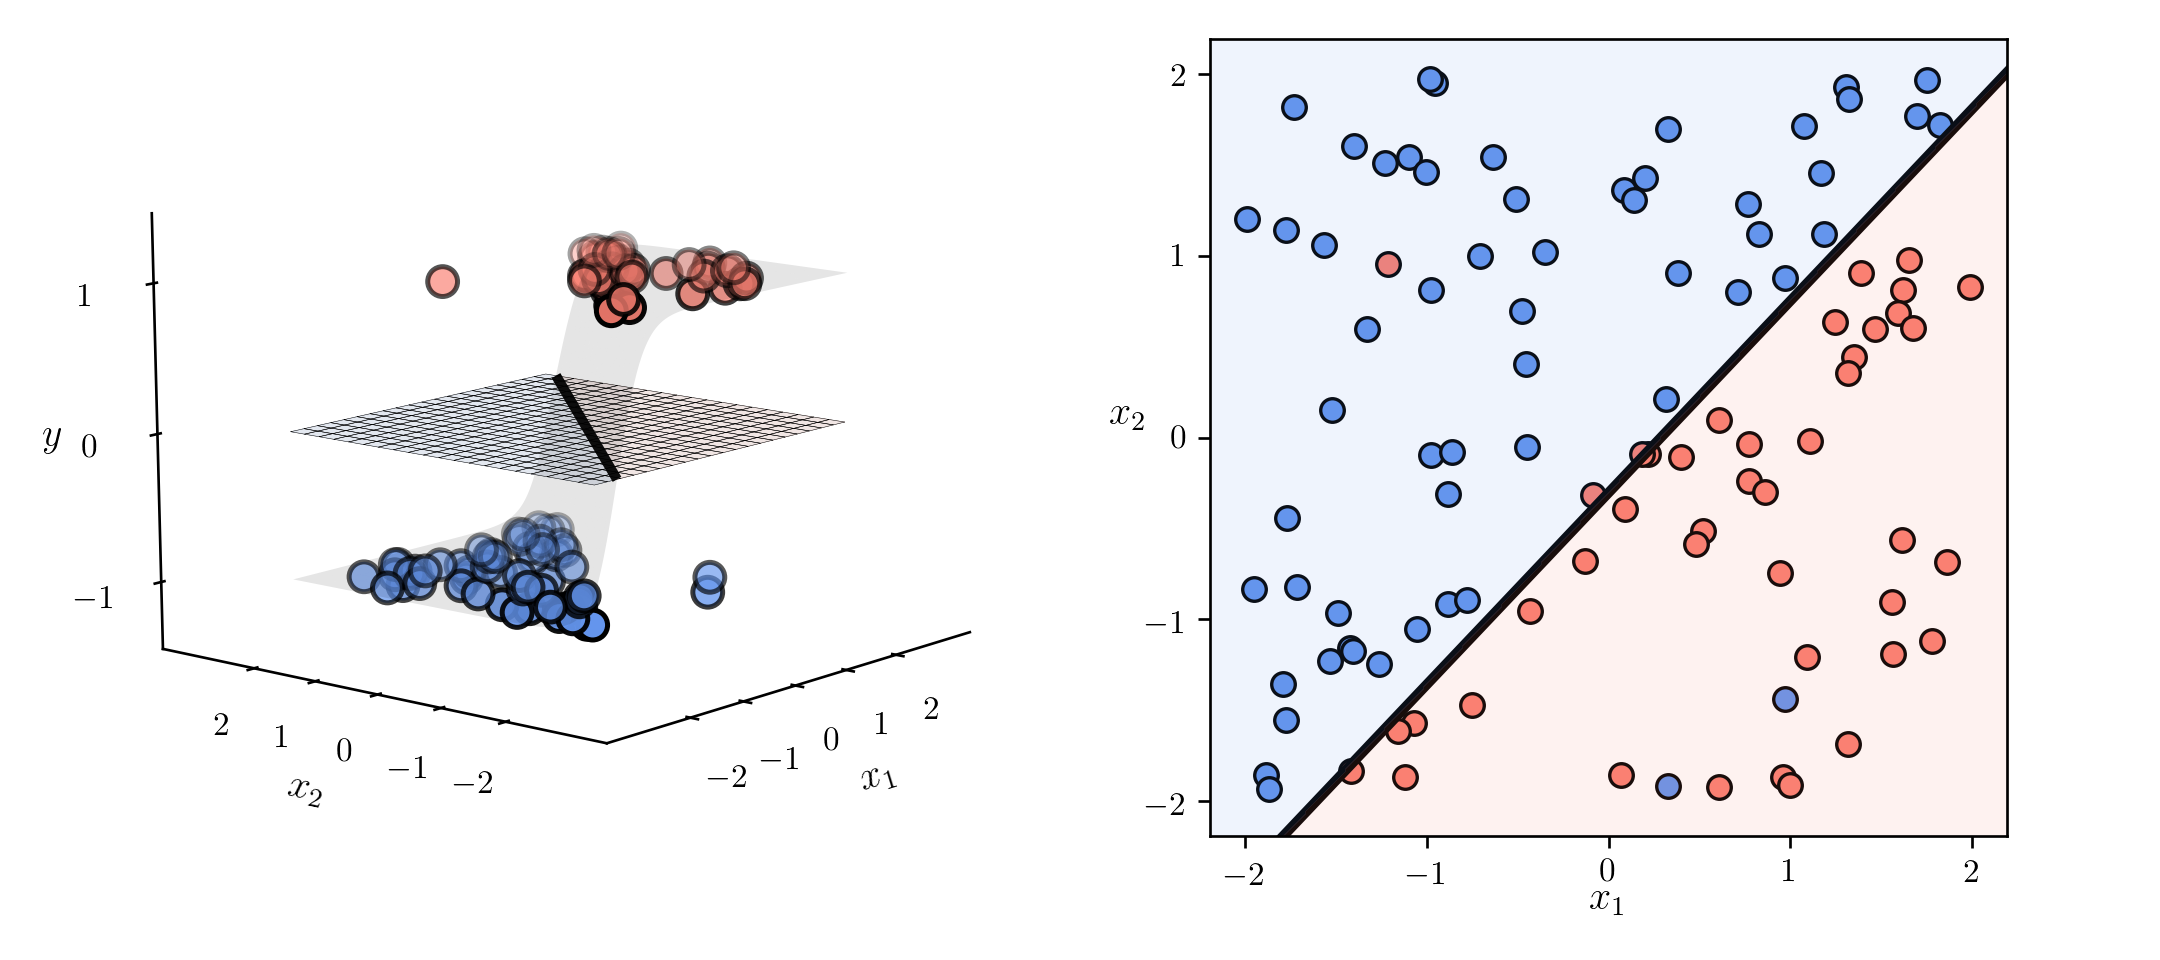

In [20]:
# This code cell will not be shown in the HTML version of this notebook
# create instance of 3d demos
demo = superlearn.classification_3d_demos.Visualizer(data)

# draw the final results
demo.static_fig(weight_history[-1],view = [15,-140])

## 9.1.7  Regularization of the separating hyperplane normal vector

Notice how in the previous example, that when applying Newton's method  to minimize the softmax cost on a *perfectly* linearly separable dataset that the weights will tend to grow very large (as the global minimum of such a function lies at infinity).  Because Newton's method takes such enormous steps towards this minimum we can very quickly run into numerical issues with weights of extremely large size.  

One common way to deal with this potentiality is to restrict the size of the *normal vector* of the separating hyperplane (defined in Subsection 6.2.3) as it is being learned.  Doing this also prevents the bias from growing out of control as well. 

In our compact notation designating the *full* set of weights - the bias and normal vector - we write

\begin{equation}
\mathbf{w} = 
\begin{bmatrix}
w_0 \\
w_1 \\
w_2 \\ 
\vdots \\
w_N
\end{bmatrix}
\end{equation}

Here the *bias* is the firsr term $w_0$, with the remaining entries $w_1$ through $w_N$ constituting the normal vector.  

Because will aim to restrict the size of the normal vector exclusively, we will want to use a *semi-compact* notation and expose the bias and normal vector separately as 

\begin{equation}
\text{(bias):}\,\, w_0 \,\,\,\,\,\,\,\, \text{(normal vector):} \,\,\,\,\,\, \mathbf{w} = 
\begin{bmatrix}
w_1 \\
w_2 \\ 
\vdots \\
w_N
\end{bmatrix}
\,\,\,\,\,\,\,\,\,\,\,\,\,\, \text{(input):} \,\,\,\,\,\, \mathbf{x}_p = 
\begin{bmatrix}
x_{1,p} \\
x_{2,p} \\ 
\vdots \\
x_{N,p}
\end{bmatrix}
\end{equation}

Because we are exposing the bias and normal vector separately, this means that in this semi-compact notation we will let $\mathbf{x}_p$ denote its original meaning - i.e., we do not append a $1$ to the top of the input vector.

With this semi-compact notation we can then express a linear combination of the input - which we would denote by $\mathbf{x}_p^T \mathbf{w}_{\,}^{\,}$ with our *compact* notation - as

\begin{equation}
w_0 + \mathbf{x}_p^T\mathbf{w}_{\,}^{\,}.
\end{equation}

Following, the softmax cost function of a set of $P$ points - which we write as $\frac{1}{P}\sum_{p=1}^P\text{log}\left(1 + e^{-y_p\mathbf{x}_p^T \mathbf{w}^{\,}_{\,}}\right)$ in our *comopact* notation - is written as 

\begin{equation}
\frac{1}{P}\sum_{p=1}^P\text{log}\left(1 + e^{-y_p\left(w_0 + \mathbf{x}_p^T \mathbf{w}^{\,}_{\,}\right)}\right).
\end{equation}

With this semi-commpact notation we can more easily express restrictions on the normal vector of the separating hyperplane while learning.  For example, if we strictly restrict to always be unit-length to learn all the proper parameters we have the *constrained* optimization problem.

\begin{equation}
\begin{aligned}
\underset{w_0, \,\mathbf{w}_{\,}}{\,\,\,\,\,\mbox{minimize}\,\,\,} & \,\,\,\, \frac{1}{P}\sum_{p=1}^P\text{log}\left(1 + e^{-y_p\left(w_0 + \mathbf{x}_p^T \mathbf{w}^{\,}_{\,}\right)}\right) \\
\mbox{subject to}\,\,\, & \,\,\,\,\, \left \Vert \mathbf{w} \right \Vert_2^2 = 1
\end{aligned}
\end{equation}

One way of solving this problem is via *projected gradient* -  that is by taking standard gradient descent steps and projecting the result onto the constraint.  However a more approach to solving this is to actually *relax* the problem, forming the *regularized* form of losgistic regression

\begin{equation}
\underset{w_0,\,\mathbf{w}_{\,}}{\text{minimize}} \,\,\, \frac{1}{P}\sum_{p=1}^P\text{log}\left(1 + e^{-y_p\left(w_0 + \mathbf{x}_p^T \mathbf{w}^{\,}_{\,}\right)}\right) + \lambda\, \left \Vert \mathbf{w} \right \Vert_2^2 \\
\end{equation}

where setting the regularization parameter $\lambda$ to a typically small positive value prevents the weights in the normal vector from exploding.  By adding the length of the normal vector to the softmax cost in minimizing this regularized cost we directly incentivise the recovery of small normal vectors - and by extension bias parameters. 

Regularization of this kind is very common - both in linear and nonlinear learning.  Indeed we will see further instances of it when discussing *Support Vector Machines* in this Chapter, as well as multiclass classification in the next Chapter.

## 9.1.8 Appendix

### Proof that the softmax cost function is convex

To show that the softmax cost function is convex we can use the second order definition of convexity, by which we must show that the eigenvalues of the softmax's Hessian matrix are all always nonnegative. Studying the Hessian of the softmax - which was defined algebraically in Example 4 above - we have 

\begin{equation}
\nabla^2 g\left(\mathbf{w}\right) =  \frac{1}{P}\sum_{p = 1}^P \left( \frac{1}{1 + e^{\,y_p^{\,} \mathbf{x}_p^T\mathbf{w}_{\,}^{\,}}} \right)  \left( 1 - \frac{1}{1 + e^{\,y_p^{\,} \mathbf{x}_p^T{\mathbf{w}_{\,}^{\,}}}} \right)    \, \mathbf{x}_p^{\,}\mathbf{x}_p^T.
\end{equation}

We know that the smallest eigenvalue of any square symmetric matrix is given as the minimum of the *Rayleigh quotient* (as detailed Section 6.1), i.e., the smallest value taken by 

\begin{equation}
\mathbf{z}^T \nabla^2 g\left(\mathbf{w}\right) \mathbf{z}^{\,}
\end{equation}

for any unit-length vector $\mathbf{z}$ and any possible weight vector $\mathbf{w}$. Substituting in the particular form of the Hessian here, denoting $\sigma_p = \left( \frac{1}{1 + e^{\,y_p^{\,} \mathbf{x}_p^T\mathbf{w}_{\,}^{\,}}} \right)  \left( 1 - \frac{1}{1 + e^{\,y_p^{\,} \mathbf{x}_p^T{\mathbf{w}_{\,}^{\,}}}} \right) $ for each $p$ for 
short, we have

\begin{equation}
\mathbf{z}^T \nabla^2 g\left(\mathbf{w}\right) \mathbf{z}^{\,}=
\mathbf{z}^T \left(\frac{1}{P} \sum_{p=1}^{P}\sigma_p \mathbf{x}_p^{\,}\mathbf{x}_p^T\right) \mathbf{z}^{\,} =  \frac{1}{P}\sum_{p=1}^{P}\sigma_p \left(\mathbf{z}^T\mathbf{x}_{p}^{\,}\right)\left( \mathbf{x}_{p}^T \mathbf{z}^{\,} \right) = \frac{1}{P}\sum_{p=1}^{P} \sigma_p \left(\mathbf{z}^T\mathbf{x}_{p}^{\,}\right)^2
\end{equation}

Since it is always the case that $\left(\mathbf{z}^T\mathbf{x}_{p}^{\,}\right)^2 \geq 0$ and $\sigma_p \geq 0$, it follows that the smallest value the above can take is $0$, meaning that this is the smallest possible eigenvalue of the softmax cost's Hessian.  Since this is the case, the softmax cost must be convex.

### Computation of the Lipschitz constant 

Building on the analysis above showing that the softmax cost is convex, we can likewise compute its largest possible eigenvalue by noting that the largest value $\sigma_k$ (defined previously) can take is $\frac{1}{4}$

\begin{equation}
\sigma_k \leq \frac{1}{4}
\end{equation}

Thus the largest value the *Rayleigh quotient* can take is bounded above for any $\mathbf{z}$ as 

\begin{equation}
\mathbf{z}^T \nabla^2 g\left(\mathbf{w}\right) \mathbf{z}^{\,} \leq \frac{1}{4P}\mathbf{z}^T \left(\sum_{p=1}^{P}\mathring{\mathbf{x}}_p^{\,}\mathring{\mathbf{x}}_p^T  \right) \mathbf{z}^{\,}
\end{equation}

Since the maximum value $\mathbf{z}^T \left(\sum_{p=1}^{P}\mathring{\mathbf{x}}_p^{\,}\mathring{\mathbf{x}}_p^T  \right) \mathbf{z}^{\,}$ can take is the maximum eigenvalue of the matrix $\sum_{p=1}^{P}\mathring{\mathbf{x}}_p^{\,}\mathring{\mathbf{x}}_p^T $, thus a Lipschitz constant for the softmax cost is given as

\begin{equation}
L = \frac{1}{4P}\left\Vert \sum_{p=1}^{P}\mathring{\mathbf{x}}_p^{\,}\mathring{\mathbf{x}}_p^T \right\Vert_2^2
\end{equation}

&copy; This material is not to be distributed, copied, or reused without written permission from the authors.